# Cálculo de energía del gradiente

In [2]:
using DataFrames
using Gadfly
using Cairo
using Compose
using MIToS.PDB
using Chemfiles
using Distributions
set_default_plot_size(40cm, 14cm)

In [3]:
function meta_var(s::AbstractString,v::Any)
         s=symbol(s) 
         @eval (($s) = ($v))
end

meta_var (generic function with 1 method)

In [4]:
function tognm(vtor_anm)
    vtor_gnm = Array{Float64}(convert(Int64, length(vtor_anm)/3));
    vtor_anm =  vtor_anm.^2
    for i=1:convert(Int64, length(vtor_anm)/3)
        vtor_gnm[i] = sqrt(vtor_anm[i*3-2] + vtor_anm[i*3-1] + vtor_anm[i*3])
    end
    return vtor_gnm
end

tognm (generic function with 1 method)

In [5]:
function read_ptraj_modes(file, modes_elements, norma::Bool=true)    
    modes_file=open(file, "r")
    modes_text = readdlm(modes_file, skipstart=0, skipblanks=true, 
    ignore_invalid_chars=true, comments=true, comment_char='\*')
    close(modes_file)

    nmodes = modes_text[1, 5]
    ncoords = convert(Int64, modes_elements)
    lines = ceil(Int64, ncoords/7)
    rest = convert(Int64, ncoords % 7)
    
    eval=Array{Float64}(nmodes);
    mode = Array{Float64}(ncoords, nmodes);
    temp1=Array{Float64}(ncoords, 1);
    temp2 = Array{Float64}(ncoords+(7-rest));

    j=lines + 1 + 2 # 1 p/ q lea la prox linea 2 por el header

    for i=1:nmodes
        eval[i] = modes_text[j, 2]
        temp = transpose(modes_text[(j+1):(lines+j), :])
        temp2 = reshape(temp, ncoords+(7-rest))
        for k=(rest+1):7
            pop!(temp2)
        end
    mode[:, i] = temp2
        j = j + lines + 1
    end
    
    if norma == true
        for i=1:nmodes
            mode[: ,i] = mode[:, i] / norm(mode[:, i])
        end
    end
    
    return mode, eval
end

read_ptraj_modes (generic function with 2 methods)

In [6]:
function displaceAA(mod_pdb, vector1, multiplier)
  # Preparo variables
   pdb = copy(mod_pdb)
   struct_xyz = coordinatesmatrix(pdb)
   new_struct_xyz = copy(struct_xyz)
   natom = Array{Int64}(1)
    vector = Array{Float64}(1, 3)
   aa = length(pdb)
   # Determino el nro de atomos de c/ aminoácido
   for i=1:aa
       push!(natom, length(pdb[i]))
   end  
   shift!(natom)
   temp1 = Array{Int64}(natom[1],3)

   # Adapto el vector p/ darle la misma forma q la matriz de coordenadas
    for i=1:3:length(vector1)
        if i== 1
            vector = reshape(vector1[i:i+2], 1, 3)
            continue
        end
        vector = vcat(vector, reshape(vector1[i:i+2], 1, 3))
    end

   for i=1:aa
       if i == 1         
           temp1 = repmat(vector[i, :], natom[i], 1)
           continue
       end  
       temp2 = repmat(vector[i, :], natom[i], 1)
       temp1 = vcat(temp1, temp2)
   end  
   sum_mat = temp1

   # Listo, ahora puedo mover el pdb
   new_struct_xyz  = struct_xyz + sum_mat .* multiplier
   pdb = change_coordinates(pdb, new_struct_xyz);
   return pdb
end

displaceAA (generic function with 1 method)

In [7]:
function WeightedHist(in_vec, in_bins, in_weight, density = false)
    # Safety check    
    if length(in_vec) != length(in_weight)
        println("Each element of the input vector needs one weight")
        return
    end
    
    # Prepare variables
    out_counts = Array{Float64}(length(in_bins)-1)
    
    # Get weighted histogram
    for i=1:length(in_bins)-1
        temp_bool = (in_vec .>= in_bins[i]) & (in_vec .< in_bins[i+1])
        out_counts[i] = sum(in_weight[temp_bool])
    end
    
    # Get bins middle points
    out_middle = (in_bins[1:end-1] + in_bins[2:end]) / 2
    
    # Turn counts into density
    if (density == true)
        out_counts = out_counts ./ sum(out_counts) 
    end
    return out_counts, out_middle
end

WeightedHist (generic function with 2 methods)

In [8]:
function Weighted_Acu(in_y, in_x, bin_count)
    in_y = in_y .^2
    
    # Safety check    
    if length(in_y) != length(in_x)
        println("Each element of the input vector needs one weight")
        return
    end
    
    # Prepare variables
    bin_size = ceil((maximum(evals_1hvr_apo) - minimum(evals_1hvr_apo)) / bin_count)
    out_y = Array{Float64, 1}(bin_count)
    out_x = collect(1:bin_count) .* bin_size - 0.5 .* bin_size

    for i = 1:bin_count
        edge = bin_size * i
        out_y[i] = sum(in_y[in_x .< edge])
    end
    
    return out_x, out_y
end

Weighted_Acu (generic function with 1 method)

In [34]:
function energia_gdte(evals::Array{Float64, 1}, gdte::Array{Float64, 1}, d::Float64 = 1.)

    if length(evals) != length(gdte)
        error("Lengths of evals and gdte don't match. Aborting.") 
    end
    
    # Declaro cte de boltzmann, avogadro, y temperatura.
    KB = 1.38064852e-23
    avgdro = 6.0221409e+23
    T = 298
    KBT = 0.593 # 
    cte = 11792.08316093831
    
    return d^2 * 0.5 * KBT * sum(evals.^2 .* gdte.^2) / cte # KJ/mol
end

energia_gdte (generic function with 2 methods)

In [35]:
function energia_modes(evals::Array{Float64, 1}, d::Float64 = 1.)
    
    # Declaro cte de boltzmann, avogadro, y temperatura.
    KB = 1.38064852e-23
    avgdro = 6.0221409e+23
    T = 298
    KBT = 0.593 # 
    cte = 11792.08316093831

    return d^2 * 0.5 * KBT * sum(evals.^2) / cte # KJ/mol
end

energia_modes (generic function with 2 methods)

In [54]:
function E_modes_wvgv(evals::Array{Float64, 1}, gdte::Array{Float64, 1}, d::Float64 = 1.)

    if length(evals) != length(gdte)
        error("Lengths of evals and gdte don't match. Aborting.") 
    end
    
    # Declaro cte de boltzmann, avogadro, y temperatura.
    KB = 1.38064852e-23
    avgdro = 6.0221409e+23
    T = 298
    KBT = 0.593 # 
    cte = 11792.08316093831
    
    return d^2 * 0.5 * KBT * (evals.^2 .* gdte.^2) / cte # KJ/mol
end

E_modes_wvgv (generic function with 2 methods)

In [61]:
function E_modes(evals::Array{Float64, 1}, d::Float64 = 1.)
    
    # Declaro cte de boltzmann, avogadro, y temperatura.
    KB = 1.38064852e-23
    avgdro = 6.0221409e+23
    T = 298
    KBT = 0.593 # 
    cte = 11792.08316093831
    
    return d^2 * 0.5 * KBT * evals.^2 / cte # KJ/mol
end

E_modes (generic function with 2 methods)

# Energía

In [11]:
# Preparo variables
points = 21
max = floor(points / 2)
min = -max
main_dir = "/home/german/labo/16/exs/"

KB = 1.38064852e-23
avgdro = 6.0221409e+23
T = 298
j_to_cal = 0.239006
KBT = KB * avgdro * 298 / 1000 * j_to_cal

0.5921873307347288

### 1hvr_apo

In [12]:
pdb_1hvr_apo = read(string(main_dir, "cavities/bu/avg_1hvr_apo.pdb"), PDBFile, group="ATOM");

# Obtengo el nro de aa's
aa_1hvr_apo = length(pdb_1hvr_apo)
aa3_1hvr_apo = aa_1hvr_apo * 3

# Leo los modos de PCA. Ya tienen cortados a los aminoácidos de los extremos.
modes_1hvr_apo, evals_1hvr_apo = read_ptraj_modes(string(main_dir, "run/1hvr_apo/pca/modes_1hvr_apo"),
                                    aa3_1hvr_apo);

# Leo gradiente
df_gdte_whole_1hvr_apo = readtable(string(main_dir, "paper/misc/gdte_1hvr_apo"))
gdte_whole_1hvr_apo = convert(Array{Float64,1 }, df_gdte_whole_1hvr_apo[:delta]);

# Obtengo barrido de energías
E_1hvr_apo = Array{Float64,1}(points)
i = 0
for d = min:max
    i+=1
    disp = d * 1e-1
    E_1hvr_apo[i] = energia_gdte(evals_1hvr_apo, gdte_whole_1hvr_apo, disp)
end

######
# Ahora con los pnum
#####
# Obtengo el pnumber
pnumber_gdte_1hvr_apo = convert(Int64, round(sum(gdte_whole_1hvr_apo .^ 4) .^ -1))
# Obtengo los índices de los 1eros "pnumber" modos
indices_pnum_modes_1hvr_apo = sortperm(abs(gdte_whole_1hvr_apo), rev=true)[1:pnumber_gdte_1hvr_apo]
indices_pnum_modes_1hvr_apo = sort(indices_pnum_modes_1hvr_apo);

# Me quedo con los ∇Volumen de los "pnumber" modos y normalizo.
gdte_whole_1hvr_apo_pnum = gdte_whole_1hvr_apo[indices_pnum_modes_1hvr_apo];
gdte_whole_1hvr_apo_pnum = gdte_whole_1hvr_apo_pnum / norm(gdte_whole_1hvr_apo_pnum)
# Me quedo con las frequencias de los "pnumber" modos.
evals_1hvr_apo_pnum = evals_1hvr_apo[indices_pnum_modes_1hvr_apo];

# Obtengo barrido de energías p/ los pnumber modos
E_1hvr_apo_pnum = Array{Float64,1}(points)
i = 0
for d = min:max
    i+=1
    disp = d * 5e-2
    E_1hvr_apo_pnum[i] = energia_gdte(evals_1hvr_apo_pnum, gdte_whole_1hvr_apo_pnum, disp)
end

# Obtengo barrido de energías p/ todos los modos
E_1hvr_apo = Array{Float64,1}(points)
i = 0
for d = min:max
    i+=1
    disp = d * 5e-2
    E_1hvr_apo[i] = energia_gdte(evals_1hvr_apo, gdte_whole_1hvr_apo, disp)
end

# Obtengo barrido de energías p/ todos los modos y sin sus autovalores
E_1hvr_apo_modes = Array{Float64,1}(points)
i = 0
for d = min:max
    i+=1
    disp = d * 2e-3
    E_1hvr_apo_modes[i] = energia_modes(evals_1hvr_apo, disp)
end

### 1hvr_hol

In [13]:
pdb_1hvr_hol = read(string(main_dir, "cavities/bu/avg_1hvr_hol.pdb"), PDBFile, group="ATOM");

# Obtengo el nro de aa's
aa_1hvr_hol = length(pdb_1hvr_hol)
aa3_1hvr_hol = aa_1hvr_hol * 3

# Leo los modos de PCA. Ya tienen cortados a los aminoácidos de los extremos.
modes_1hvr_hol, evals_1hvr_hol = read_ptraj_modes(string(main_dir, "run/1hvr_hol/pca/modes_1hvr_hol"),
                                    aa3_1hvr_hol);

# Leo gradiente
df_gdte_whole_1hvr_hol = readtable(string(main_dir, "paper/misc/gdte_1hvr_hol"))
gdte_whole_1hvr_hol = convert(Array{Float64,1 }, df_gdte_whole_1hvr_hol[:delta]);

# Obtengo barrido de energías
E_1hvr_hol = Array{Float64,1}(points)
i = 0
for d = min:max
    i+=1
    disp = d * 1e-1
    E_1hvr_hol[i] = energia_gdte(evals_1hvr_hol, gdte_whole_1hvr_hol, disp)
end

######
# Ahora con los pnum
#####
# Obtengo el pnumber
pnumber_gdte_1hvr_hol = convert(Int64, round(sum(gdte_whole_1hvr_hol .^ 4) .^ -1))
# Obtengo los índices de los 1eros "pnumber" modos
indices_pnum_modes_1hvr_hol = sortperm(abs(gdte_whole_1hvr_hol), rev=true)[1:pnumber_gdte_1hvr_hol]
indices_pnum_modes_1hvr_hol = sort(indices_pnum_modes_1hvr_hol);

# Me quedo con los ∇Volumen de los "pnumber" modos y normalizo.
gdte_whole_1hvr_hol_pnum = gdte_whole_1hvr_hol[indices_pnum_modes_1hvr_hol];
gdte_whole_1hvr_hol_pnum = gdte_whole_1hvr_hol_pnum / norm(gdte_whole_1hvr_hol_pnum)
# Me quedo con las frequencias de los "pnumber" modos
evals_1hvr_hol_pnum = evals_1hvr_hol[indices_pnum_modes_1hvr_hol];

# Obtengo barrido de energías p/ todos los modos
E_1hvr_hol_pnum = Array{Float64,1}(points)
i = 0
for d = min:max
    i+=1
    disp = d * 5e-2
    E_1hvr_hol_pnum[i] = energia_gdte(evals_1hvr_hol_pnum, gdte_whole_1hvr_hol_pnum, disp)
end

# Obtengo barrido de energías p/ los pnumber modos
E_1hvr_hol = Array{Float64,1}(points)
i = 0
for d = min:max
    i+=1
    disp = d * 5e-2
    E_1hvr_hol[i] = energia_gdte(evals_1hvr_hol, gdte_whole_1hvr_hol, disp)
end

# Obtengo barrido de energías p/ todos los modos y sin sus autovalores
E_1hvr_hol_modes = Array{Float64,1}(points)
i = 0
for d = min:max
    i+=1
    disp = d * 2e-3
    E_1hvr_hol_modes[i] = energia_modes(evals_1hvr_hol, disp)
end

### 1m14

In [14]:
pdb_1m14 = read(string(main_dir, "run/1m14/pca/cut_avg_1m14.pdb"), PDBFile, group="ATOM");

# Obtengo el nro de aa's
aa_1m14 = length(pdb_1m14)
aa3_1m14 = aa_1m14 * 3

# Leo los modos de PCA. Ya tienen cortados a los aminoácidos de los extremos.
modes_1m14, evals_1m14 = read_ptraj_modes(string(main_dir, "run/1m14/pca/modes_1m14"),
                                    aa3_1m14);

# Leo gradiente
df_gdte_whole_1m14 = readtable(string(main_dir, "paper/misc/gdte_1m14"))
gdte_whole_1m14 = convert(Array{Float64,1 }, df_gdte_whole_1m14[:delta]);

# Obtengo barrido de energías
E_1m14 = Array{Float64,1}(points)
i = 0
for d = min:max
    i+=1
    disp = d * 1e-1
    E_1m14[i] = energia_gdte(evals_1m14, gdte_whole_1m14, disp)
end

######
# Ahora con los pnum
#####
# Obtengo el pnumber
pnumber_gdte_1m14 = convert(Int64, round(sum(gdte_whole_1m14 .^ 4) .^ -1)) 
# Obtengo los índices de los 1eros "pnumber" modos
indices_pnum_modes_1m14 = sortperm(abs(gdte_whole_1m14), rev=true)[1:pnumber_gdte_1m14]
indices_pnum_modes_1m14 = sort(indices_pnum_modes_1m14);

# Me quedo con los ∇Volumen de los "pnumber" modos y normalizo.
gdte_whole_1m14_pnum = gdte_whole_1m14[indices_pnum_modes_1m14];
gdte_whole_1m14_pnum = gdte_whole_1m14_pnum / norm(gdte_whole_1m14_pnum)
# Me quedo con las frequencias de los "pnumber" modos
evals_1m14_pnum = evals_1m14[indices_pnum_modes_1m14];

# Obtengo barrido de energías p/ todos los modos
E_1m14_pnum = Array{Float64,1}(points)
i = 0
for d = min:max
    i+=1
    disp = d * 5e-2
    E_1m14_pnum[i] = energia_gdte(evals_1m14_pnum, gdte_whole_1m14_pnum, disp)
end

# Obtengo barrido de energías p/ los pnumber modos
E_1m14 = Array{Float64,1}(points)
i = 0
for d = min:max
    i+=1
    disp = d * 5e-2
    E_1m14[i] = energia_gdte(evals_1m14, gdte_whole_1m14, disp)
end

# Obtengo barrido de energías p/ todos los modos y sin sus autovalores
E_1m14_modes = Array{Float64,1}(points)
i = 0
for d = min:max
    i+=1
    disp = d * 2e-3
    E_1m14_modes[i] = energia_modes(evals_1m14, disp)
end

### 256l

In [15]:
pdb_256l = read(string(main_dir, "run/256l/pca/cut_avg_256l.pdb"), PDBFile, group="ATOM");

# Obtengo el nro de aa's
aa_256l = length(pdb_256l)
aa3_256l = aa_256l * 3

# Leo los modos de PCA. Ya tienen cortados a los aminoácidos de los extremos.
modes_256l, evals_256l = read_ptraj_modes(string(main_dir, "run/256l/pca/modes_256l"),
                                    aa3_256l);

# Leo gradiente
df_gdte_whole_256l = readtable(string(main_dir, "paper/misc/gdte_256l"))
gdte_whole_256l = convert(Array{Float64,1 }, df_gdte_whole_256l[:delta]);

# Obtengo barrido de energías
E_256l = Array{Float64,1}(points)
i = 0
for d = min:max
    i+=1
    disp = d * 1e-1
    E_256l[i] = energia_gdte(evals_256l, gdte_whole_256l, disp)
end

######
# Ahora con los pnum
#####
# Obtengo el pnumber
pnumber_gdte_256l = convert(Int64, round(sum(gdte_whole_256l .^ 4) .^ -1)) 
# Obtengo los índices de los 1eros "pnumber" modos
indices_pnum_modes_256l = sortperm(abs(gdte_whole_256l), rev=true)[1:pnumber_gdte_256l]
indices_pnum_modes_256l = sort(indices_pnum_modes_256l);

# Me quedo con los ∇Volumen de los "pnumber" modos y normalizo.
gdte_whole_256l_pnum = gdte_whole_256l[indices_pnum_modes_256l];
gdte_whole_256l_pnum = gdte_whole_256l_pnum / norm(gdte_whole_256l_pnum)
# Me quedo con las frequencias de los "pnumber" modos
evals_256l_pnum = evals_256l[indices_pnum_modes_256l];

# Obtengo barrido de energías p/ todos los modos
E_256l_pnum = Array{Float64,1}(points)
i = 0
for d = min:max
    i+=1
    disp = d * 5e-2
    E_256l_pnum[i] = energia_gdte(evals_256l_pnum, gdte_whole_256l_pnum, disp)
end

# Obtengo barrido de energías p/ los pnumber modos
E_256l = Array{Float64,1}(points)
i = 0
for d = min:max
    i+=1
    disp = d * 5e-2
    E_256l[i] = energia_gdte(evals_256l, gdte_whole_256l, disp)
end

# Obtengo barrido de energías p/ todos los modos y sin sus autovalores
E_256l_modes = Array{Float64,1}(points)
i = 0
for d = min:max
    i+=1
    disp = d * 2e-3
    E_256l_modes[i] = energia_modes(evals_256l, disp)
end

## Plots

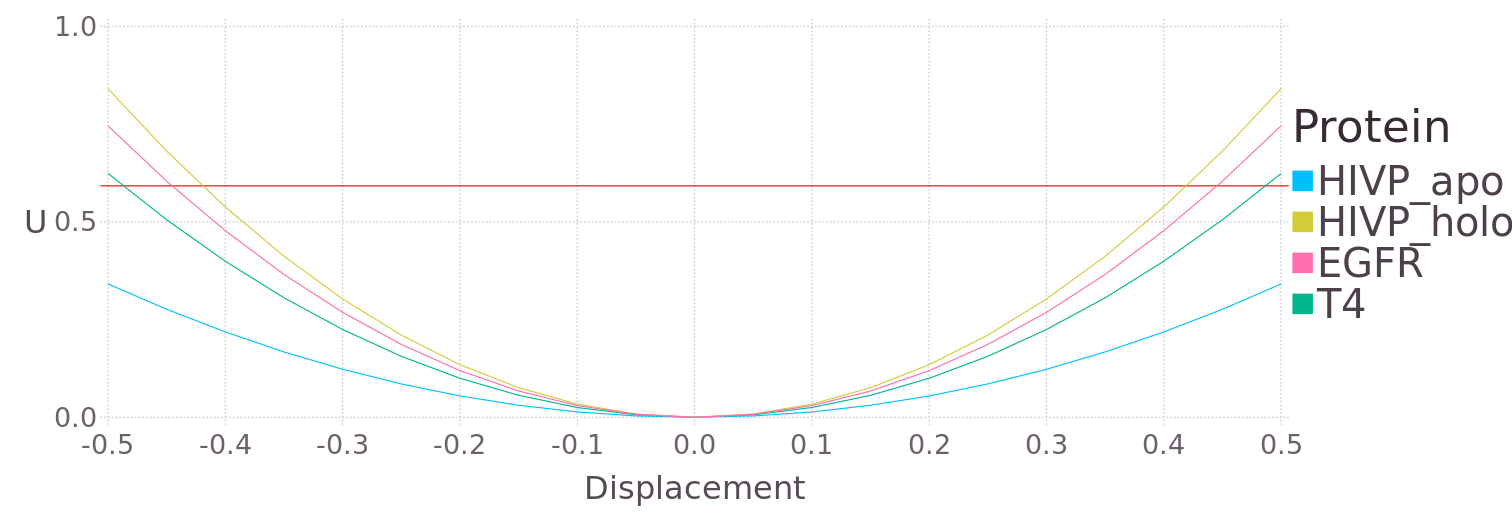

In [16]:
# Compilo en un dataframe.
df_E = DataFrame(U = [ E_1hvr_apo ; E_1hvr_hol ; E_1m14 ; E_256l ],
Displacement = repeat(collect(min:1:max) * 5e-2, outer = [4]), 
Protein = repeat(["HIVP_apo" ; "HIVP_holo" ; "EGFR" ; "T4"], inner = [points]))

pdf_E = plot(df_E, y = "U", x = "Displacement", color = "Protein", Geom.line,
yintercept = [KBT], Geom.hline(color = "red"),
Guide.xticks(ticks = collect(min:2:max) * 5e-2),

Theme(bar_spacing=2pt, grid_line_width=1pt, Theme(default_color=colorant"deepskyblue"),
minor_label_font_size = 20pt, major_label_font_size = 24pt, key_title_font_size = 34pt,
key_label_font_size = 30pt))

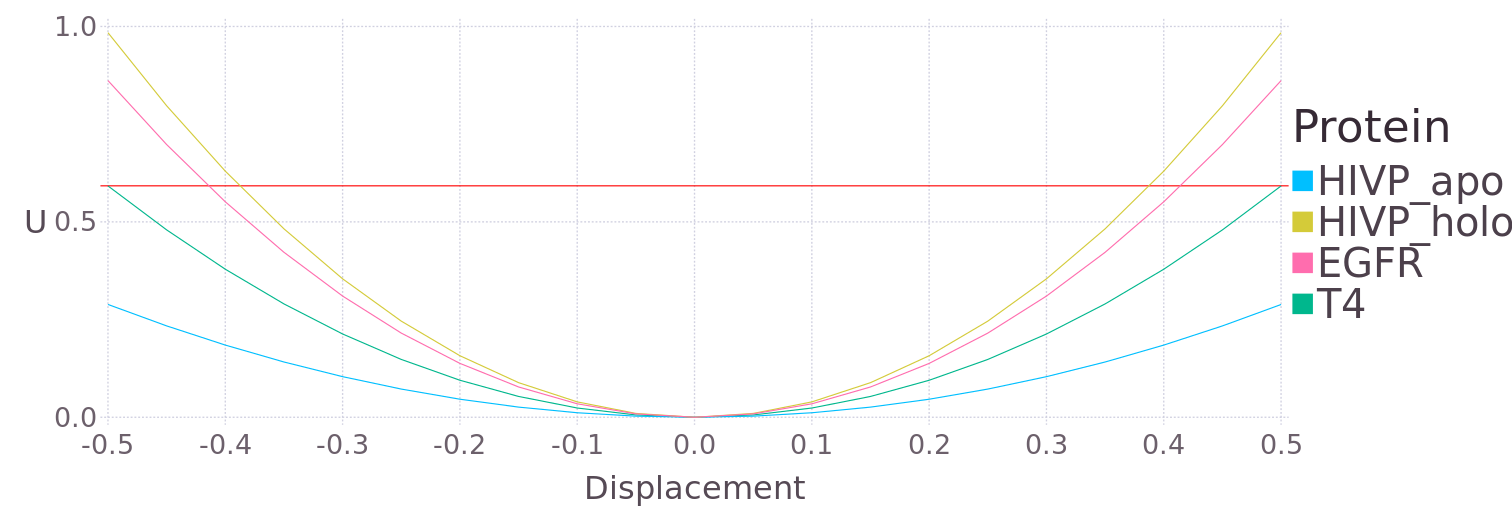

In [17]:
# Compilo en un dataframe.
df_E_pnum = DataFrame(U = [ E_1hvr_apo_pnum ; E_1hvr_hol_pnum ; E_1m14_pnum ; E_256l_pnum ],
Displacement = repeat(collect(min:1:max) * 5e-2, outer = [4]), 
Protein = repeat(["HIVP_apo" ; "HIVP_holo" ; "EGFR" ; "T4"], inner = [points]))


pdf_E_pnum = plot(df_E_pnum, y = "U", x = "Displacement", color = "Protein", Geom.line,
yintercept = [KBT], Geom.hline(color = "red"),
Guide.xticks(ticks = collect(min:2:max) * 5e-2),

Theme(bar_spacing=2pt, grid_line_width=1pt, Theme(default_color=colorant"deepskyblue"),
minor_label_font_size = 20pt, major_label_font_size = 24pt, key_title_font_size = 34pt,
key_label_font_size = 30pt))

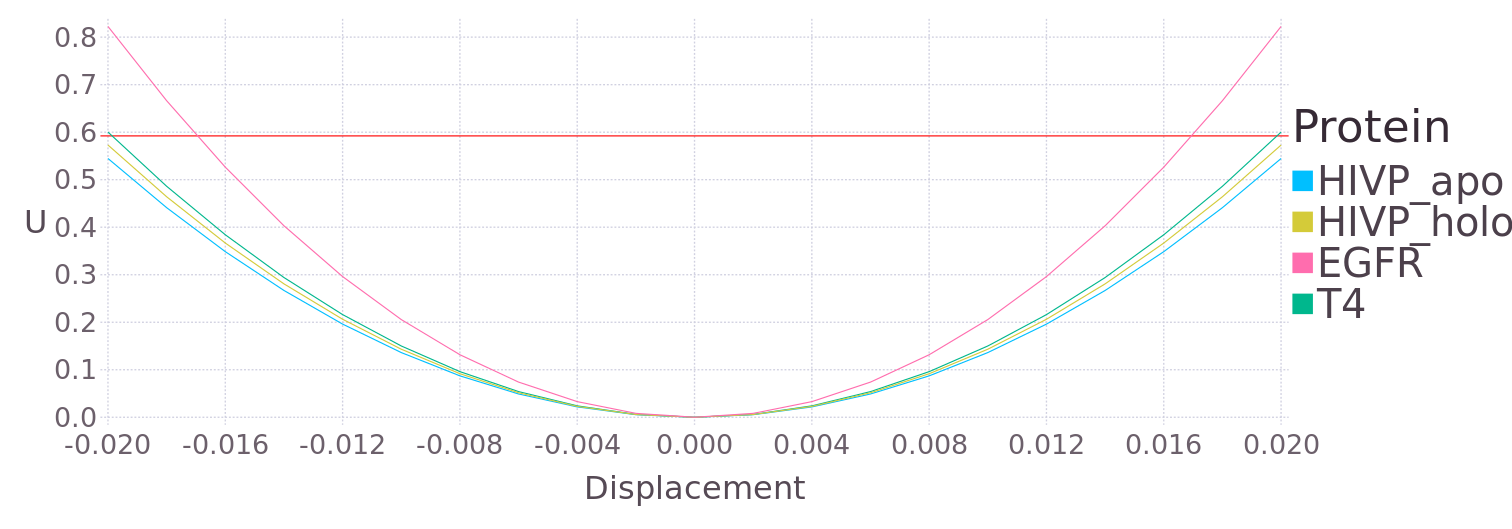

In [18]:
# Compilo en un dataframe.
df_E_modes = DataFrame(U = [ E_1hvr_apo_modes ; E_1hvr_hol_modes ; E_1m14_modes ; E_256l_modes ],
Displacement = repeat(collect(min:1:max) * 2e-3, outer = [4]), 
Protein = repeat(["HIVP_apo" ; "HIVP_holo" ; "EGFR" ; "T4"], inner = [points]))


pdf_E_modes = plot(df_E_modes, y = "U", x = "Displacement", color = "Protein", Geom.line,
yintercept = [KBT], Geom.hline(color = "red"),
Guide.xticks(ticks = collect(min:2:max) * 2e-3),
Guide.yticks(ticks = collect(0.0:0.1:maximum(df_E_modes[:U]))),

Theme(bar_spacing=2pt, grid_line_width=1pt, Theme(default_color=colorant"deepskyblue"),
minor_label_font_size = 20pt, major_label_font_size = 24pt, key_title_font_size = 34pt,
key_label_font_size = 30pt))

## Acumulados

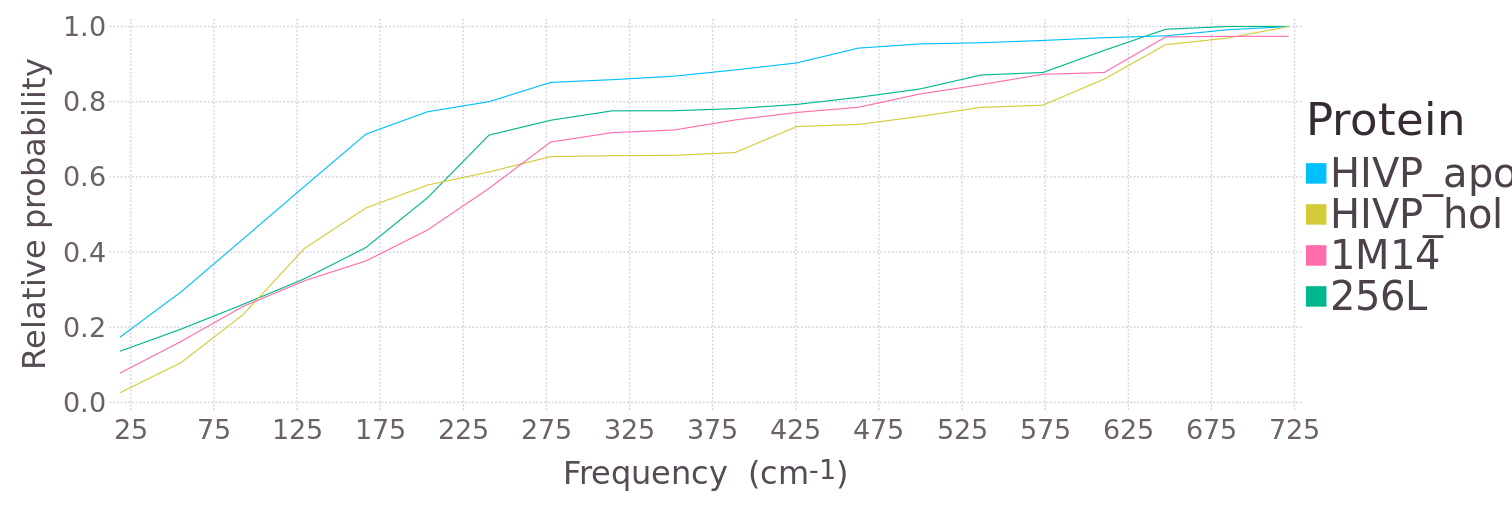

In [19]:
bin_count = 20
acu_x_1hvr_apo, acu_y_1hvr_apo = Weighted_Acu(gdte_whole_1hvr_apo,  evals_1hvr_apo, bin_count)
acu_x_1hvr_hol, acu_y_1hvr_hol = Weighted_Acu(gdte_whole_1hvr_hol,  evals_1hvr_hol, bin_count)
acu_x_1m14, acu_y_1m14 = Weighted_Acu(gdte_whole_1m14,  evals_1m14, bin_count)
acu_x_256l, acu_y_256l = Weighted_Acu(gdte_whole_256l,  evals_256l, bin_count)

df_acu = DataFrame(Fraction = [ acu_y_1hvr_apo ; acu_y_1hvr_hol ; acu_y_1m14 ; acu_y_256l ],
Frequency = [ acu_x_1hvr_apo ; acu_x_1hvr_hol ; acu_x_1m14 ; acu_x_256l ],
Protein = repeat(["HIVP_apo" ; "HIVP_hol" ; "1M14" ; "256L" ], inner = [bin_count]))

pdf_acu = plot(df_acu, y = "Fraction", x = "Frequency", color = "Protein", Geom.line,
Coord.cartesian(ymax = 1.0, xmin = minimum(df_acu[:Frequency])* .9),
Guide.xticks(ticks = collect(25:50:750)), Guide.yticks(ticks = collect(0:0.2:1.)),
Guide.xlabel("Frequency  (cm<sup>-1</sup>)"), Guide.ylabel("Relative probability"),

Theme(bar_spacing=2pt, grid_line_width=1pt, Theme(default_color=colorant"deepskyblue"),
minor_label_font_size = 20pt, major_label_font_size = 24pt, key_title_font_size = 34pt,
key_label_font_size = 30pt))

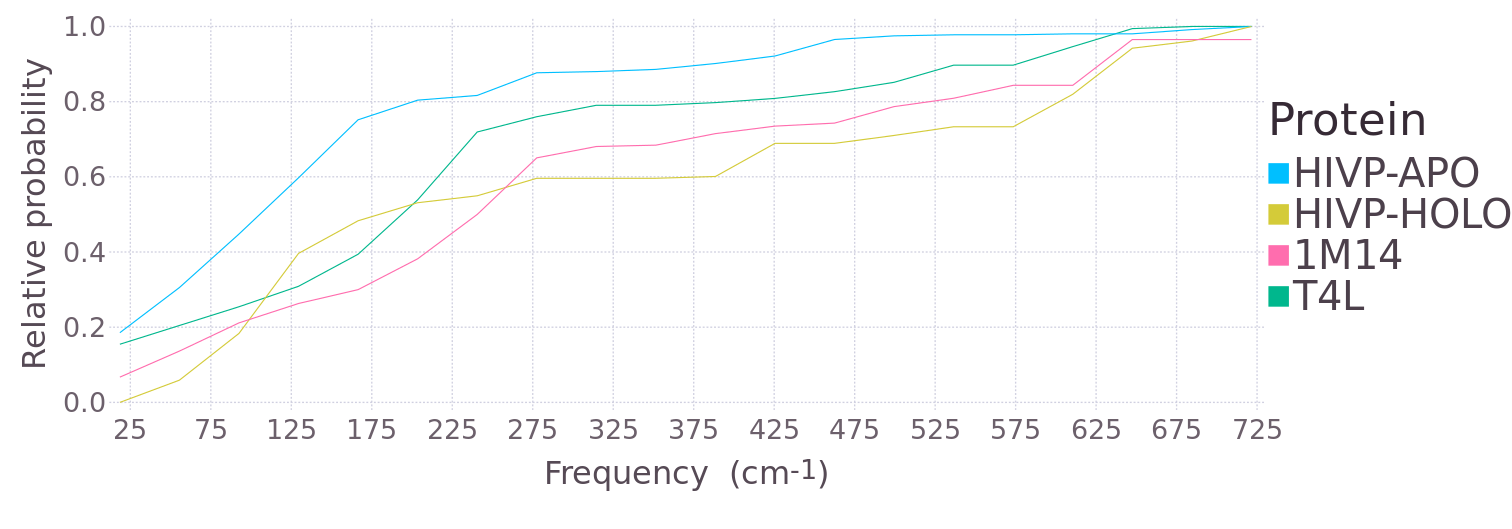

In [20]:
bin_count = 20
acu_x_1hvr_apo_pnum, acu_y_1hvr_apo_pnum = Weighted_Acu(gdte_whole_1hvr_apo_pnum,  evals_1hvr_apo_pnum, bin_count)
acu_x_1hvr_hol_pnum, acu_y_1hvr_hol_pnum = Weighted_Acu(gdte_whole_1hvr_hol_pnum,  evals_1hvr_hol_pnum, bin_count)
acu_x_1m14_pnum, acu_y_1m14_pnum = Weighted_Acu(gdte_whole_1m14_pnum,  evals_1m14_pnum, bin_count)
acu_x_256l_pnum, acu_y_256l_pnum = Weighted_Acu(gdte_whole_256l_pnum,  evals_256l_pnum, bin_count)

df_acu_pnum = DataFrame(Fraction = [ acu_y_1hvr_apo_pnum ; acu_y_1hvr_hol_pnum ; acu_y_1m14_pnum ; acu_y_256l_pnum ],
Frequency = [ acu_x_1hvr_apo_pnum ; acu_x_1hvr_hol_pnum ; acu_x_1m14_pnum ; acu_x_256l_pnum ],
Protein = repeat(["HIVP-APO" ; "HIVP-HOLO" ; "1M14" ; "T4L" ], inner = [bin_count]))

pdf_acu_pnum = plot(df_acu_pnum, y = "Fraction", x = "Frequency", color = "Protein", Geom.line,
Coord.cartesian(ymax = 1.0, xmin = minimum(df_acu[:Frequency])* .9),
Guide.xticks(ticks = collect(25:50:750)), Guide.yticks(ticks = collect(0:0.2:1.)),
Guide.xlabel("Frequency  (cm<sup>-1</sup>)"), Guide.ylabel("Relative probability"),

Theme(bar_spacing=2pt, grid_line_width=1pt, Theme(default_color=colorant"deepskyblue"),
minor_label_font_size = 20pt, major_label_font_size = 24pt, key_title_font_size = 34pt,
key_label_font_size = 30pt))

# VGV, Whistograms, ΔE

In [67]:
#### HIVP-APO
# Obtengo energy de c/ modo
e_modes_1hvr_apo = E_modes(evals_1hvr_apo_pnum)

# Obtengo weighted energy de c/ modo
we_modes_1hvr_apo = E_modes_wvgv(evals_1hvr_apo_pnum, gdte_whole_1hvr_apo_pnum);
####

#### HIVP-HOLO
# Obtengo energy de c/ modo
e_modes_1hvr_hol = E_modes(evals_1hvr_hol_pnum)

# Obtengo weighted energy de c/ modo
we_modes_1hvr_hol = E_modes_wvgv(evals_1hvr_hol_pnum, gdte_whole_1hvr_hol_pnum);
####

#### HIVP-APO
# Obtengo energy de c/ modo
e_modes_1m14 = E_modes(evals_1m14_pnum)

# Obtengo weighted energy de c/ modo
we_modes_1m14 = E_modes_wvgv(evals_1m14_pnum, gdte_whole_1m14_pnum);
####

#### HIVP-APO
# Obtengo energy de c/ modo
e_modes_256l = E_modes(evals_256l_pnum)

# Obtengo weighted energy de c/ modo
we_modes_256l = E_modes_wvgv(evals_256l_pnum, gdte_whole_256l_pnum);

## HIVP-APO

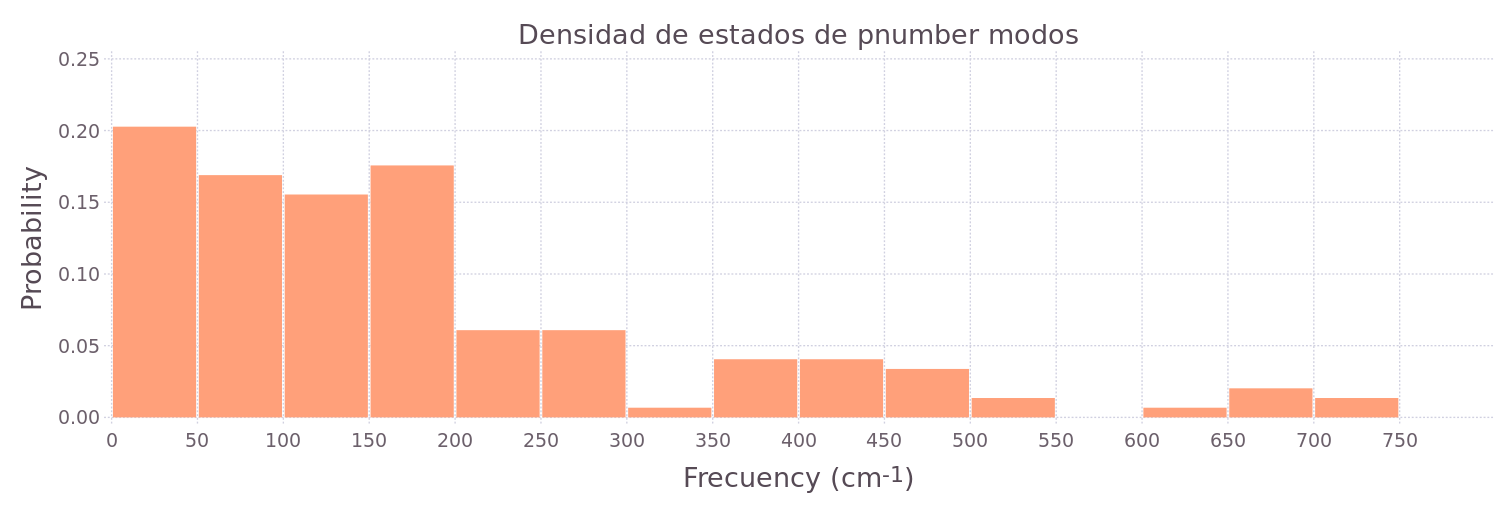

In [63]:
# Los bins van de 0 a la fqcia más alta + 10%
top_freq = maximum(evals_1hvr_apo_pnum) * 1.1
bins_freq = collect(0:50:top_freq)
unos_freq = repeat([1.0], inner=[length(evals_1hvr_apo_pnum)])

# Histograma no ponderado
mode_freq_1hvr_apo_his, mode_freq_1hvr_apo_bins =
WeightedHist(evals_1hvr_apo_pnum, bins_freq, unos_freq, true);

df_mode_freq_1hvr_apo_his =
DataFrame(Probability = mode_freq_1hvr_apo_his, Frequency = mode_freq_1hvr_apo_bins);

pdf_mode_freq_1hvr_apo_his = plot(df_mode_freq_1hvr_apo_his, x="Frequency", y="Probability", Geom.bar,
Guide.title("Densidad de estados de pnumber modos"),
Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), Guide.xticks(ticks=collect(0:50:775)),
Guide.ylabel("Probability", orientation=:vertical),
Theme(bar_spacing=2pt, grid_line_width=1pt, default_color=colorant"LightSalmon",
minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

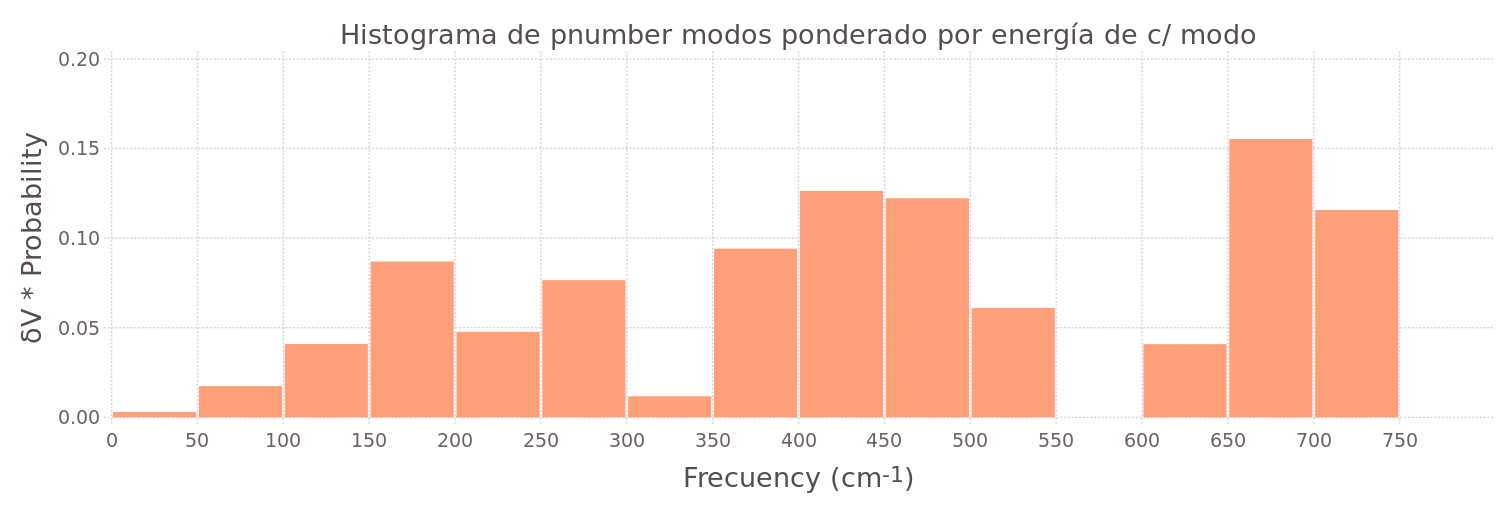

In [64]:
# Los bins van de 0 a la fqcia más alta + 10%
top_freq = maximum(evals_1hvr_apo_pnum) * 1.1
bins_freq = collect(0:50:top_freq)

# Histograma ponderado
mode_freq_1hvr_apo_Whis, mode_freq_1hvr_apo_Wbins =
WeightedHist(evals_1hvr_apo_pnum, bins_freq, e_modes_1hvr_apo, true);

df_mode_freq_1hvr_apo_Whis =
DataFrame(Probability = mode_freq_1hvr_apo_Whis, Frequency = mode_freq_1hvr_apo_Wbins);

pdf_mode_freq_1hvr_apo_Whis = plot(df_mode_freq_1hvr_apo_Whis, x="Frequency", y="Probability", Geom.bar,
Guide.title("Histograma de pnumber modos ponderado por energía de c/ modo"),
Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), Guide.xticks(ticks=collect(0:50:775)),
Guide.ylabel("δV * Probability", orientation=:vertical),
Theme(bar_spacing=2pt, grid_line_width=1pt, default_color=colorant"LightSalmon",
minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

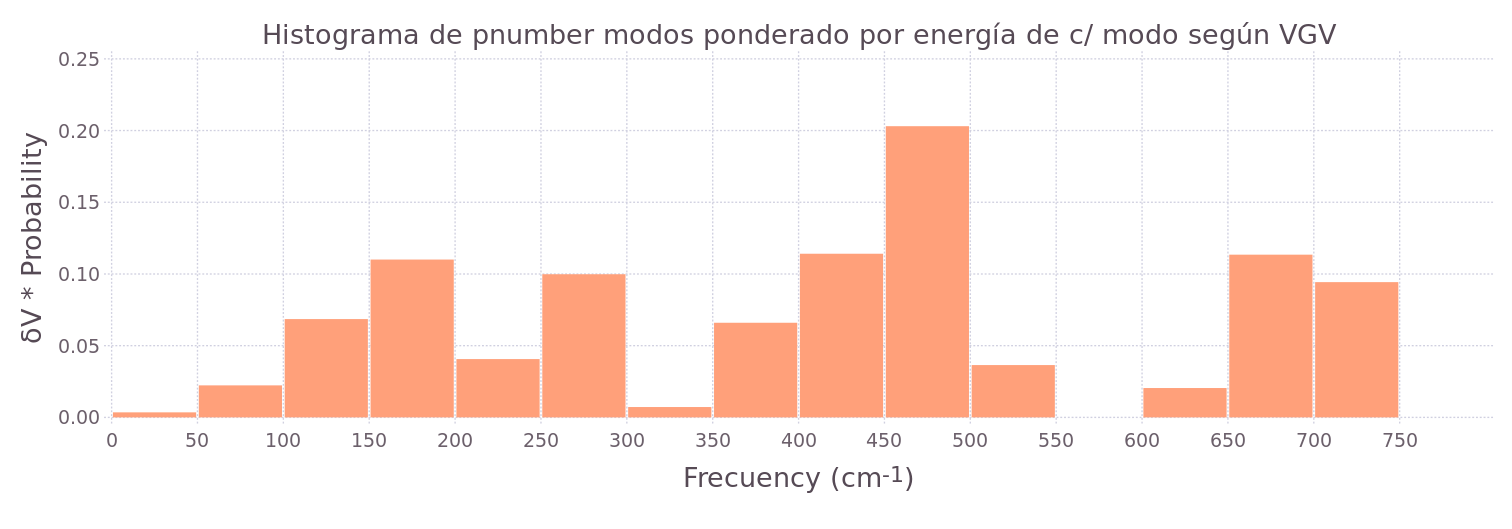

In [65]:
# Los bins van de 0 a la fqcia más alta + 10%
top_freq = maximum(evals_1hvr_apo_pnum) * 1.1
bins_freq = collect(0:50:top_freq)

# Histograma ponderado
mode_freq_1hvr_apo_Whis, mode_freq_1hvr_apo_Wbins =
WeightedHist(evals_1hvr_apo_pnum, bins_freq, we_modes_1hvr_apo, true);

df_mode_freq_1hvr_apo_Whis =
DataFrame(Probability = mode_freq_1hvr_apo_Whis, Frequency = mode_freq_1hvr_apo_Wbins);

pdf_mode_freq_1hvr_apo_Whis = plot(df_mode_freq_1hvr_apo_Whis, x="Frequency", y="Probability", Geom.bar,
Guide.title("Histograma de pnumber modos ponderado por energía de c/ modo según VGV"),
Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), Guide.xticks(ticks=collect(0:50:775)),
Guide.ylabel("δV * Probability", orientation=:vertical),
Theme(bar_spacing=2pt, grid_line_width=1pt, default_color=colorant"LightSalmon",
minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

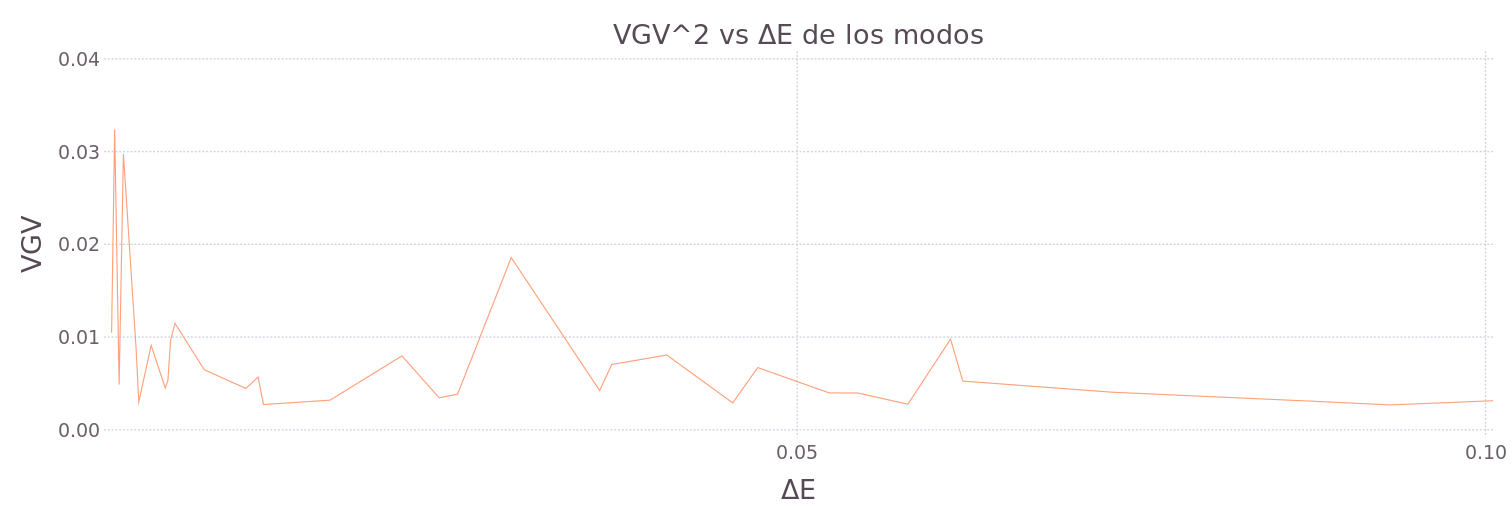

In [87]:
df_vgv_e_1hvr_apo =
DataFrame(VGV = gdte_whole_1hvr_apo_pnum.^2, ΔΕ = e_modes_1hvr_apo);

pdf_vgv_e_1hvr_apo = plot(df_vgv_e_1hvr_apo, x="ΔΕ", y="VGV", Geom.line,
Guide.title("VGV^2 vs ΔE de los modos"),
Coord.cartesian(xmax = 0.1),

Theme(bar_spacing=2pt, grid_line_width=1pt, default_color=colorant"LightSalmon",
minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

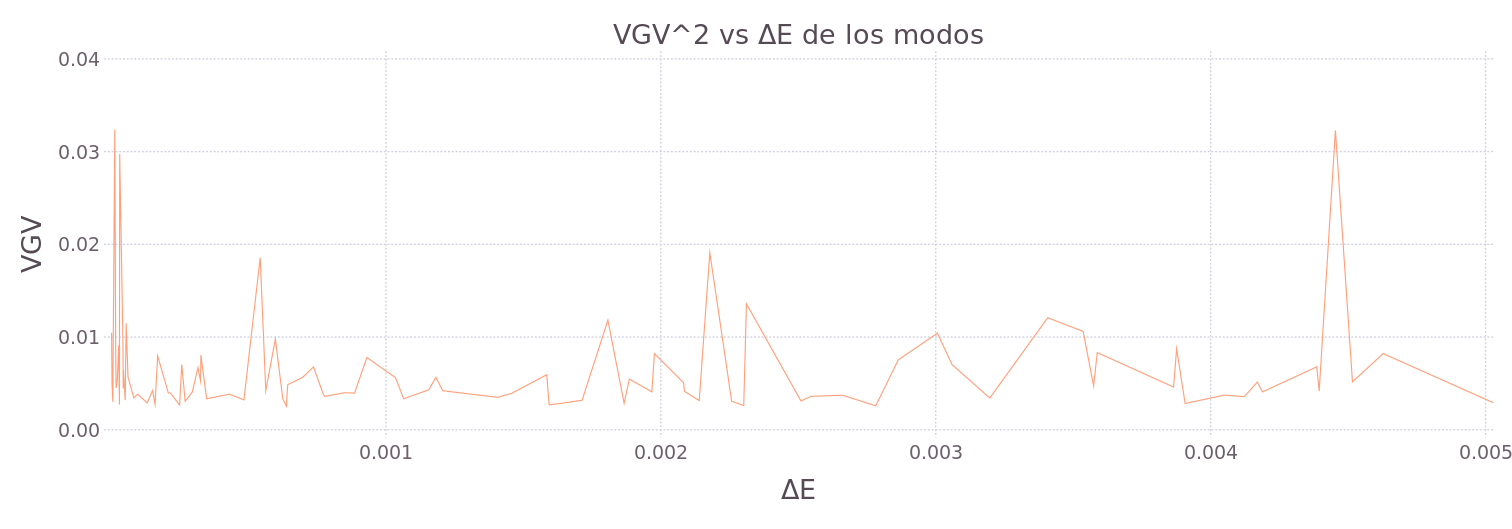

In [90]:
df_vgv_we_1hvr_apo =
DataFrame(VGV = gdte_whole_1hvr_apo_pnum.^2, ΔΕ = we_modes_1hvr_apo);

pdf_vgv_we_1hvr_apo = plot(df_vgv_we_1hvr_apo, x="ΔΕ", y="VGV", Geom.line,
Guide.title("VGV^2 vs ΔE de los modos"),
Coord.cartesian(xmax = 0.005),

Theme(bar_spacing=2pt, grid_line_width=1pt, default_color=colorant"LightSalmon",
minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

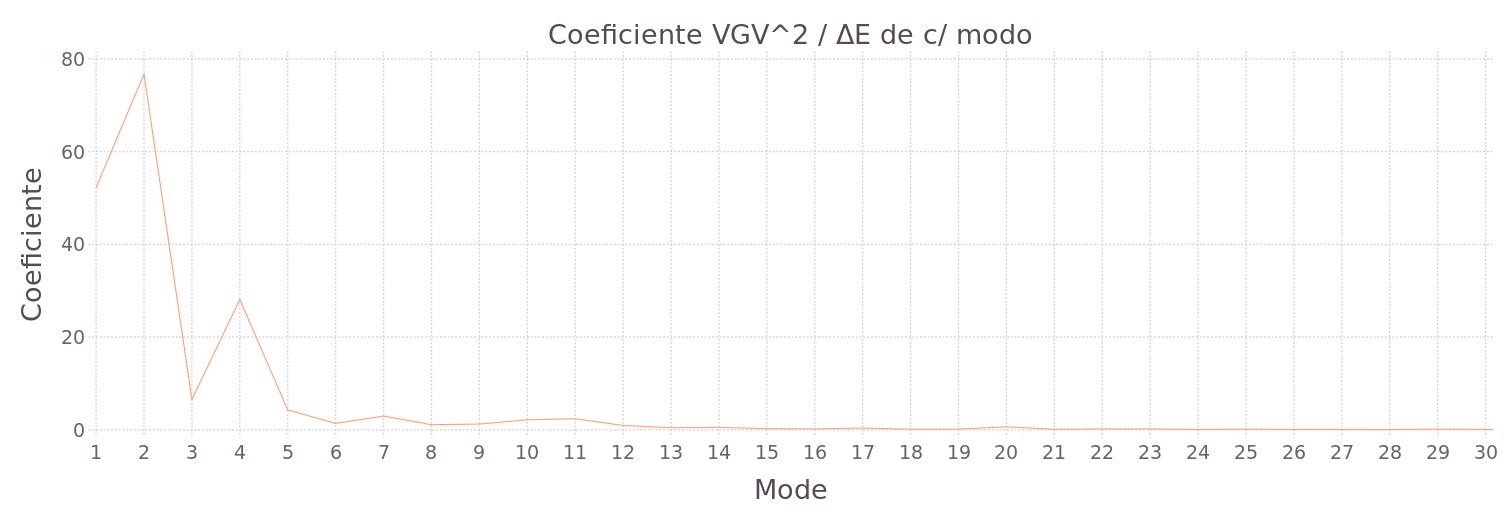

In [131]:
cfcte_modes_1hvr_apo = (gdte_whole_1hvr_apo_pnum.^2) ./ e_modes_1hvr_apo

df_cfcte_modes_1hvr_apo =
DataFrame(Coeficiente = cfcte_modes_1hvr_apo, Mode = collect(1:pnumber_gdte_1hvr_apo))

pdf_cfcte_modes_1hvr_apo = plot(df_cfcte_modes_1hvr_apo, x="Mode",
y="Coeficiente", Geom.line,
Guide.title("Coeficiente VGV^2 / ΔE de c/ modo"), Guide.xticks(ticks = collect(1:30)),
Coord.cartesian(xmax = 30),

Theme(bar_spacing=2pt, grid_line_width=1pt,
default_color=colorant"LightSalmon",
minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size
= 20pt))

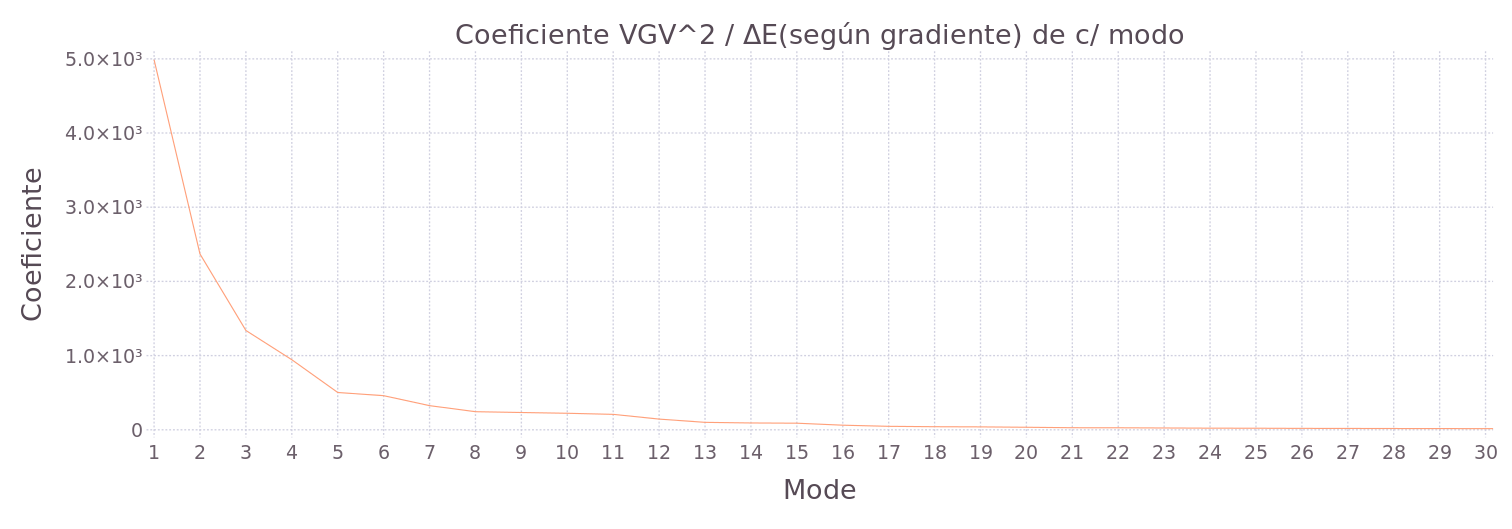

In [130]:
wcfcte_modes_1hvr_apo = (gdte_whole_1hvr_apo_pnum.^2) ./ we_modes_1hvr_apo;

df_wcfcte_modes_1hvr_apo =
DataFrame(Coeficiente = wcfcte_modes_1hvr_apo, Mode = collect(1:pnumber_gdte_1hvr_apo))

pdf_wcfcte_modes_1hvr_apo = plot(df_wcfcte_modes_1hvr_apo, x="Mode",
y="Coeficiente", Geom.line,
Guide.title("Coeficiente VGV^2 / ΔE(según gradiente) de c/ modo"), Guide.xticks(ticks = collect(1:30)),
Coord.cartesian(xmax = 30),

Theme(bar_spacing=2pt, grid_line_width=1pt,
default_color=colorant"LightSalmon",
minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size
= 20pt))

## HIVP-HOLO

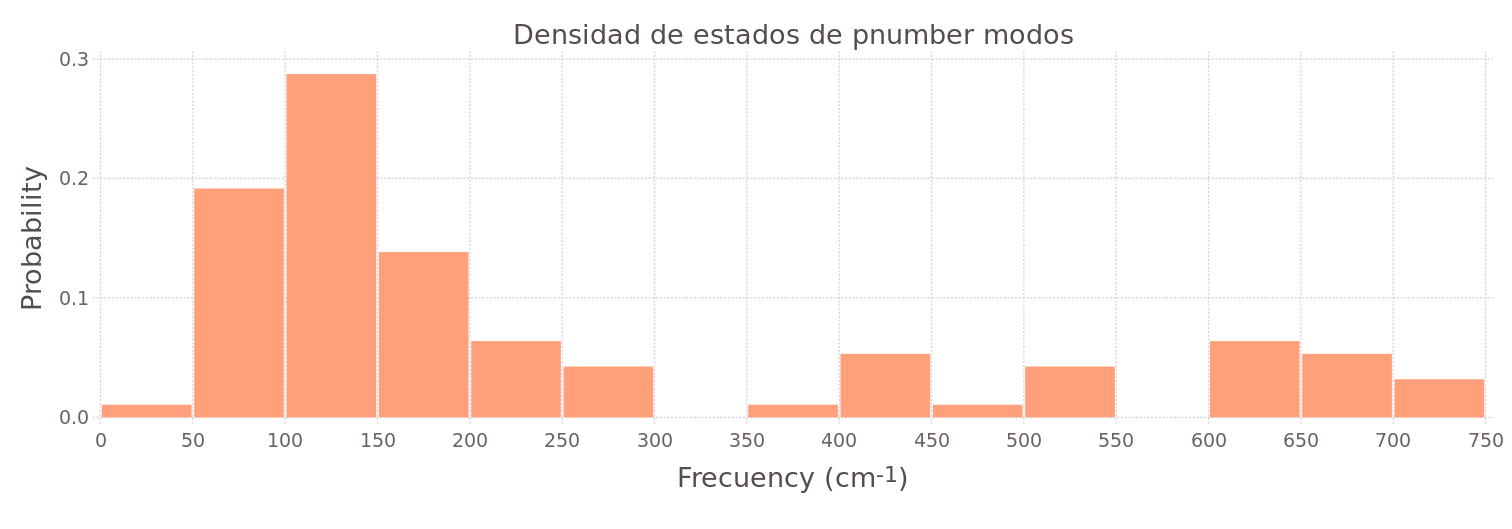

In [69]:
top_freq = maximum(evals_1hvr_hol_pnum) * 1.1
bins_freq = collect(0:50:top_freq)
unos_freq = repeat([1.0], inner=[length(evals_1hvr_hol_pnum)])

# Histograma no ponderado
mode_freq_1hvr_hol_his, mode_freq_1hvr_hol_bins =
WeightedHist(evals_1hvr_hol_pnum, bins_freq, unos_freq, true);

df_mode_freq_1hvr_hol_his =
DataFrame(Probability = mode_freq_1hvr_hol_his, Frequency =
mode_freq_1hvr_hol_bins);

pdf_mode_freq_1hvr_hol_his = plot(df_mode_freq_1hvr_hol_his, x="Frequency",
y="Probability", Geom.bar,
Guide.title("Densidad de estados de pnumber modos"),
Guide.xlabel("Frecuency (cm<sup>-1</sup>)"),
Guide.xticks(ticks=collect(0:50:775)),
Guide.ylabel("Probability", orientation=:vertical),
Theme(bar_spacing=2pt, grid_line_width=1pt,
default_color=colorant"LightSalmon",
minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size
= 20pt))

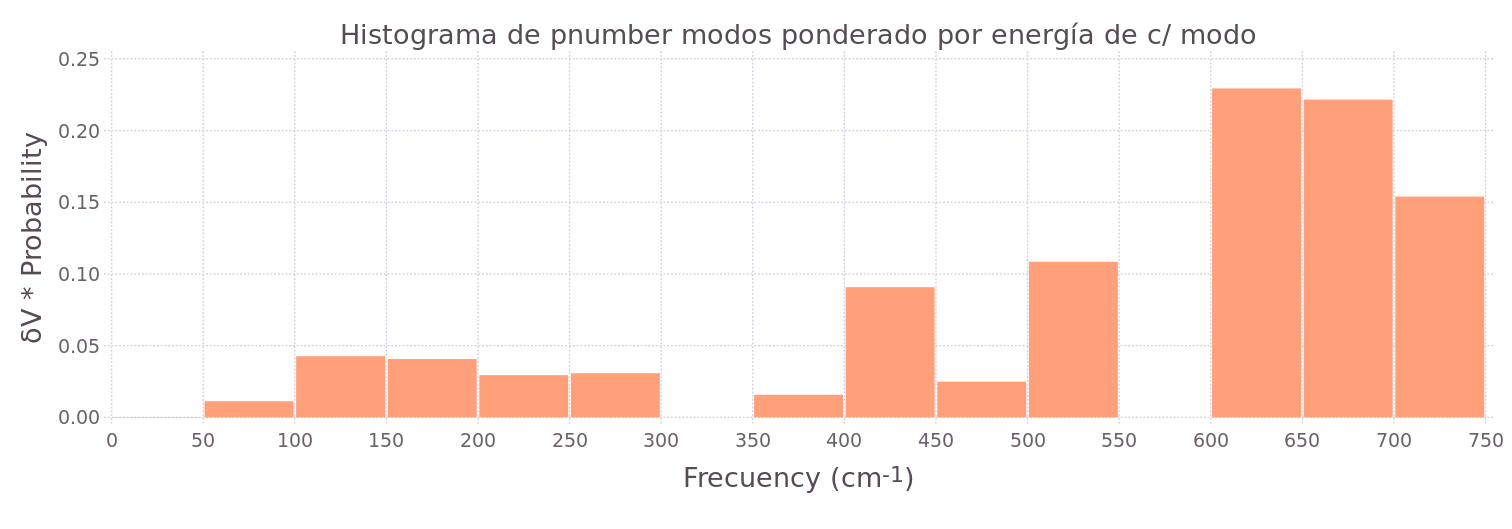

In [70]:
# Los bins van de 0 a la fqcia más alta + 10%
top_freq = maximum(evals_1hvr_hol_pnum) * 1.1
bins_freq = collect(0:50:top_freq)

# Histograma ponderado
mode_freq_1hvr_hol_Whis, mode_freq_1hvr_hol_Wbins =
WeightedHist(evals_1hvr_hol_pnum, bins_freq, e_modes_1hvr_hol, true);

df_mode_freq_1hvr_hol_Whis =
DataFrame(Probability = mode_freq_1hvr_hol_Whis, Frequency =
mode_freq_1hvr_hol_Wbins);

pdf_mode_freq_1hvr_hol_Whis = plot(df_mode_freq_1hvr_hol_Whis, x="Frequency",
y="Probability", Geom.bar,
Guide.title("Histograma de pnumber modos ponderado por energía de c/ modo"),
Guide.xlabel("Frecuency (cm<sup>-1</sup>)"),
Guide.xticks(ticks=collect(0:50:775)),
Guide.ylabel("δV * Probability", orientation=:vertical),
Theme(bar_spacing=2pt, grid_line_width=1pt,
default_color=colorant"LightSalmon",
minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size
= 20pt))

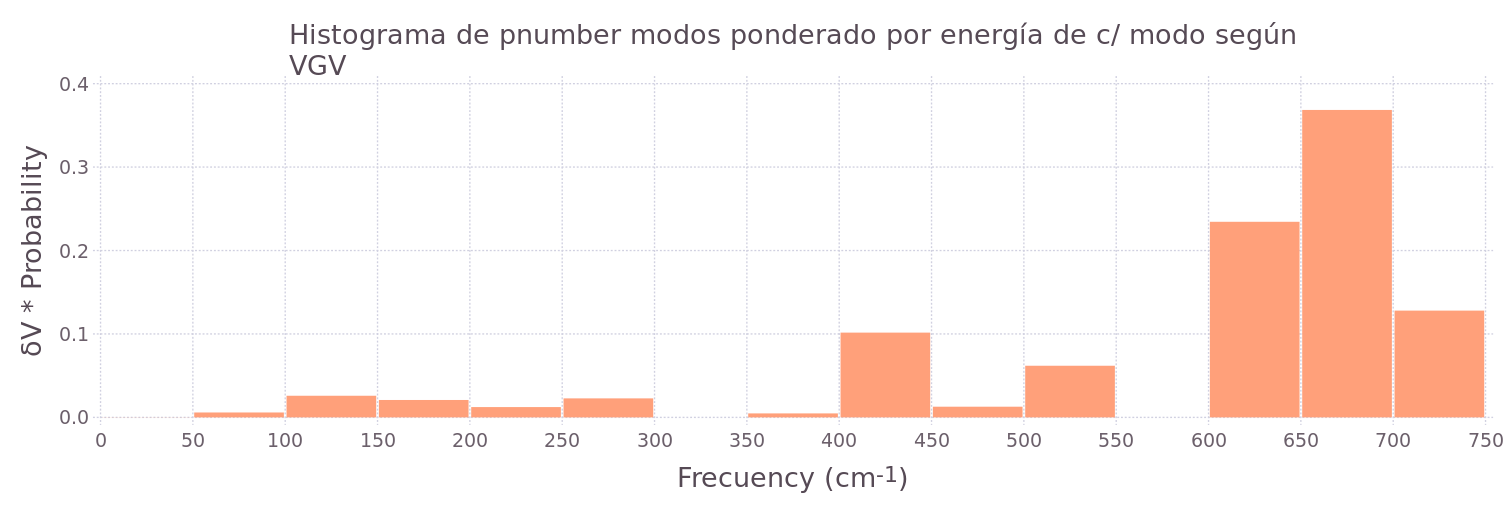

In [71]:
top_freq = maximum(evals_1hvr_hol_pnum) * 1.1
bins_freq = collect(0:50:top_freq)

# Histograma ponderado
mode_freq_1hvr_hol_Whis, mode_freq_1hvr_hol_Wbins =
WeightedHist(evals_1hvr_hol_pnum, bins_freq, we_modes_1hvr_hol, true);

df_mode_freq_1hvr_hol_Whis =
DataFrame(Probability = mode_freq_1hvr_hol_Whis, Frequency =
mode_freq_1hvr_hol_Wbins);

pdf_mode_freq_1hvr_hol_Whis = plot(df_mode_freq_1hvr_hol_Whis, x="Frequency",
y="Probability", Geom.bar,
Guide.title("Histograma de pnumber modos ponderado por energía de c/ modo según
VGV"),
Guide.xlabel("Frecuency (cm<sup>-1</sup>)"),
Guide.xticks(ticks=collect(0:50:775)),
Guide.ylabel("δV * Probability", orientation=:vertical),
Theme(bar_spacing=2pt, grid_line_width=1pt,
default_color=colorant"LightSalmon",
minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size
= 20pt))

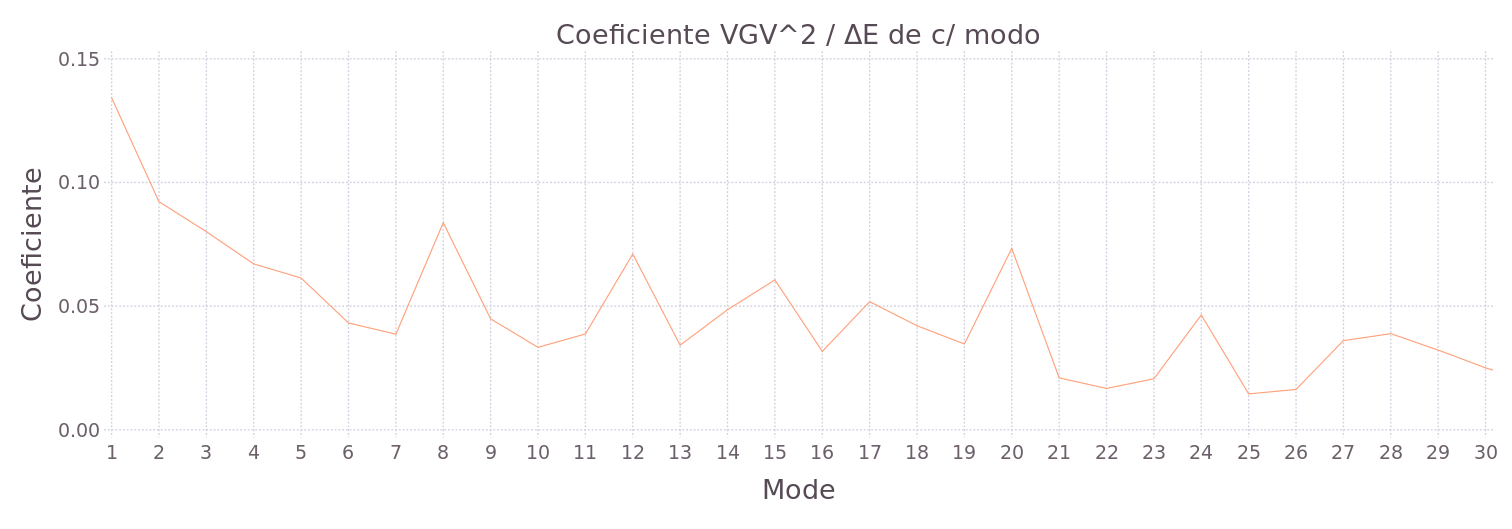

In [129]:
cfcte_modes_1hvr_hol = (gdte_whole_1hvr_hol_pnum.^2) ./ e_modes_1hvr_hol

df_cfcte_modes_1hvr_hol =
DataFrame(Coeficiente = cfcte_modes_1hvr_hol, Mode =
collect(1:pnumber_gdte_1hvr_hol))

pdf_cfcte_modes_1hvr_hol = plot(df_cfcte_modes_1hvr_hol, x="Mode",
y="Coeficiente", Geom.line,
Guide.title("Coeficiente VGV^2 / ΔE de c/ modo"), Guide.xticks(ticks = collect(1:30)),
Coord.cartesian(xmax = 30),

Theme(bar_spacing=2pt, grid_line_width=1pt,
default_color=colorant"LightSalmon",
minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size
= 20pt))

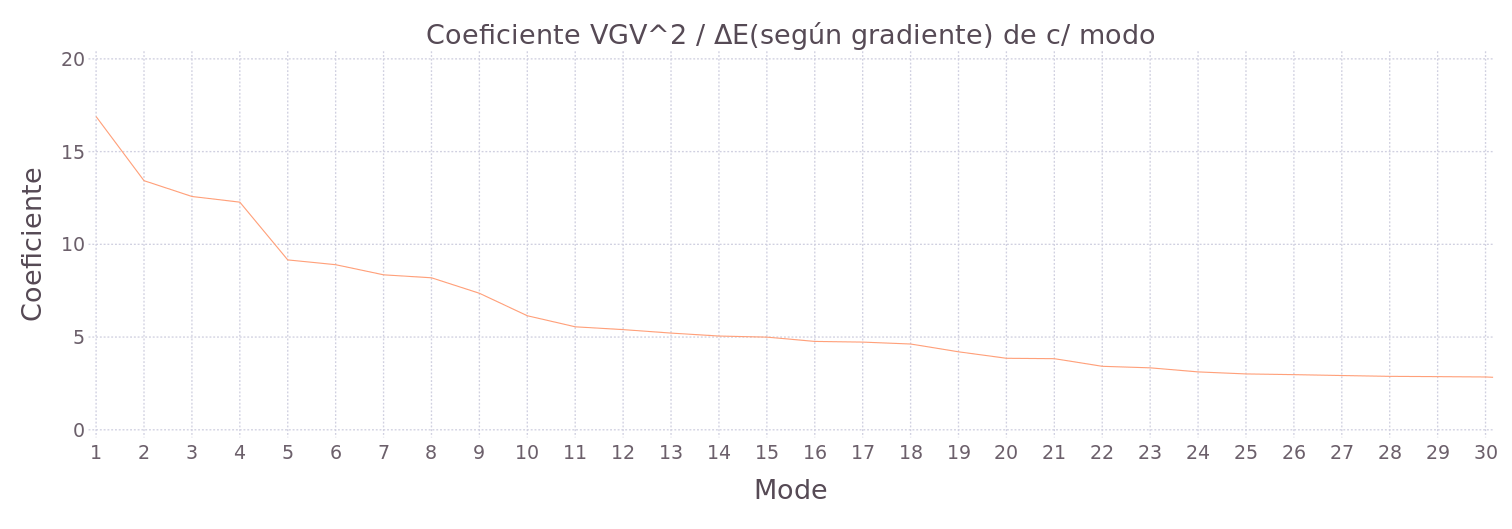

In [128]:
wcfcte_modes_1hvr_hol = (gdte_whole_1hvr_hol_pnum.^2) ./ we_modes_1hvr_hol;

df_wcfcte_modes_1hvr_hol =
DataFrame(Coeficiente = wcfcte_modes_1hvr_hol, Mode =
collect(1:pnumber_gdte_1hvr_hol))

pdf_wcfcte_modes_1hvr_hol = plot(df_wcfcte_modes_1hvr_hol, x="Mode",
y="Coeficiente", Geom.line,
Guide.title("Coeficiente VGV^2 / ΔE(según gradiente) de c/ modo"), Guide.xticks(ticks = collect(1:30)),
Coord.cartesian(xmax = 30),

Theme(bar_spacing=2pt, grid_line_width=1pt,
default_color=colorant"LightSalmon",
minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size
= 20pt))

## 1M14

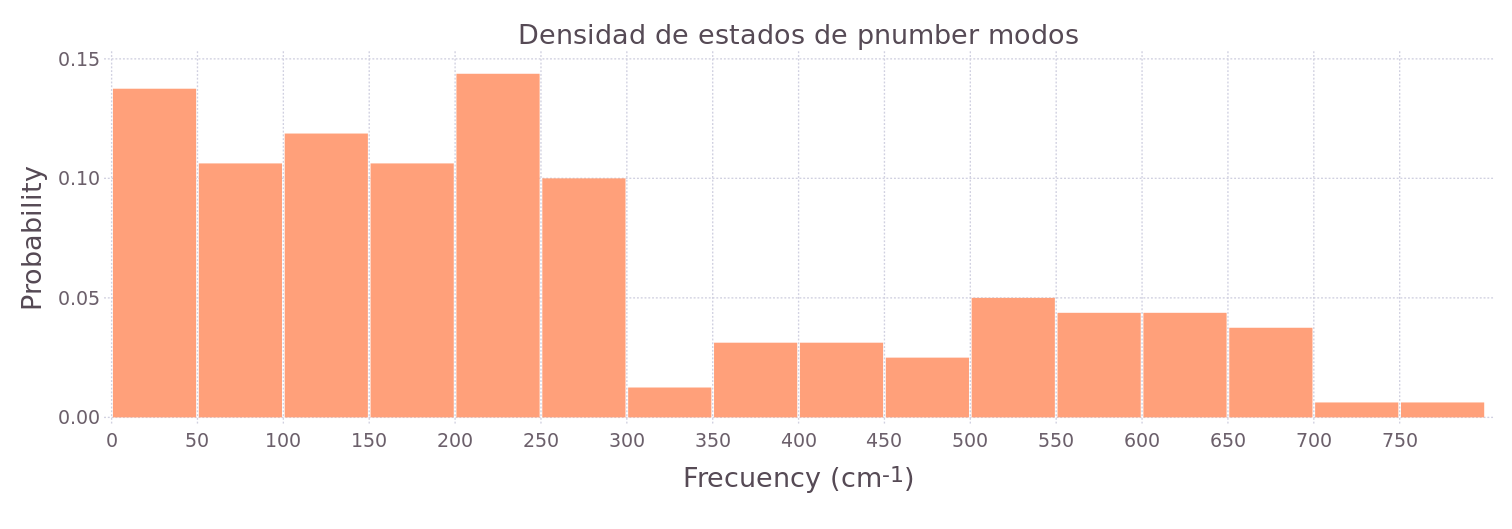

In [72]:
top_freq = maximum(evals_1m14_pnum) * 1.1 
bins_freq = collect(0:50:top_freq)
unos_freq = repeat([1.0], inner=[length(evals_1m14_pnum)])

# Histograma no ponderado
mode_freq_1m14_his, mode_freq_1m14_bins =
WeightedHist(evals_1m14_pnum, bins_freq, unos_freq, true);

df_mode_freq_1m14_his =
DataFrame(Probability = mode_freq_1m14_his, Frequency =
mode_freq_1m14_bins);

pdf_mode_freq_1m14_his = plot(df_mode_freq_1m14_his, x="Frequency",
y="Probability", Geom.bar,
Guide.title("Densidad de estados de pnumber modos"),
Guide.xlabel("Frecuency (cm<sup>-1</sup>)"),
Guide.xticks(ticks=collect(0:50:775)),
Guide.ylabel("Probability", orientation=:vertical),
Theme(bar_spacing=2pt, grid_line_width=1pt,
default_color=colorant"LightSalmon",
minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size
= 20pt))

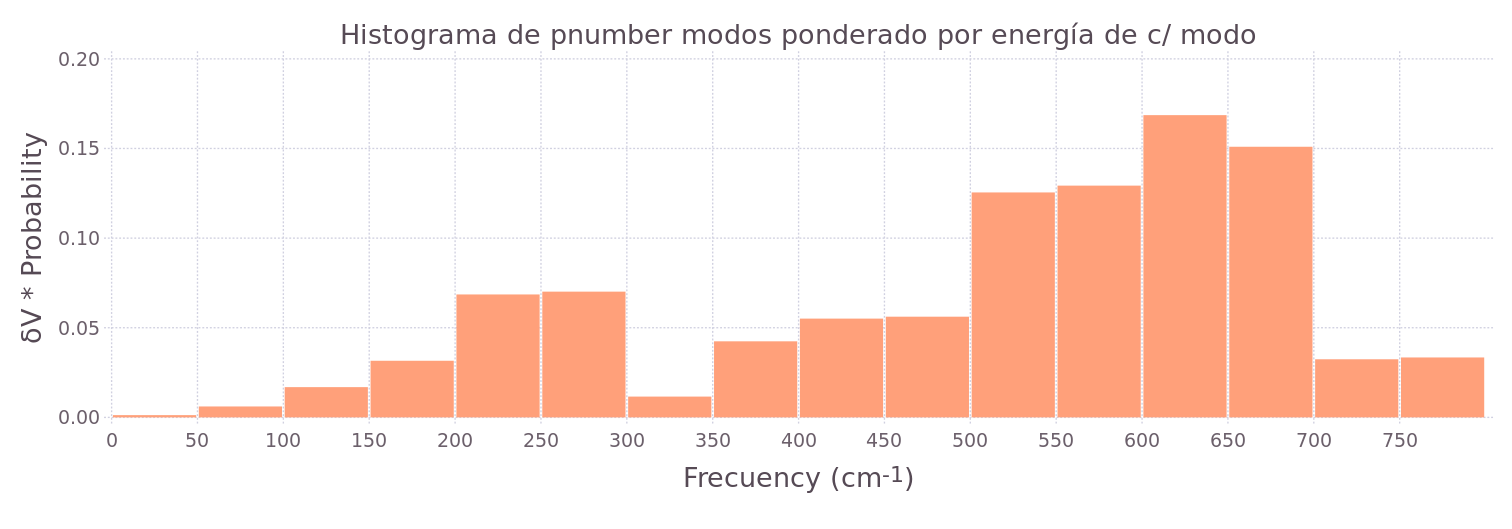

In [73]:
# Los bins van de 0 a la fqcia más alta + 10%
top_freq = maximum(evals_1m14_pnum) * 1.1 
bins_freq = collect(0:50:top_freq)

# Histograma ponderado
mode_freq_1m14_Whis, mode_freq_1m14_Wbins =
WeightedHist(evals_1m14_pnum, bins_freq, e_modes_1m14, true);

df_mode_freq_1m14_Whis =
DataFrame(Probability = mode_freq_1m14_Whis, Frequency =
mode_freq_1m14_Wbins);

pdf_mode_freq_1m14_Whis = plot(df_mode_freq_1m14_Whis, x="Frequency",
y="Probability", Geom.bar,
Guide.title("Histograma de pnumber modos ponderado por energía de c/ modo"),
Guide.xlabel("Frecuency (cm<sup>-1</sup>)"),
Guide.xticks(ticks=collect(0:50:775)),
Guide.ylabel("δV * Probability", orientation=:vertical),
Theme(bar_spacing=2pt, grid_line_width=1pt,
default_color=colorant"LightSalmon",
minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size
= 20pt))

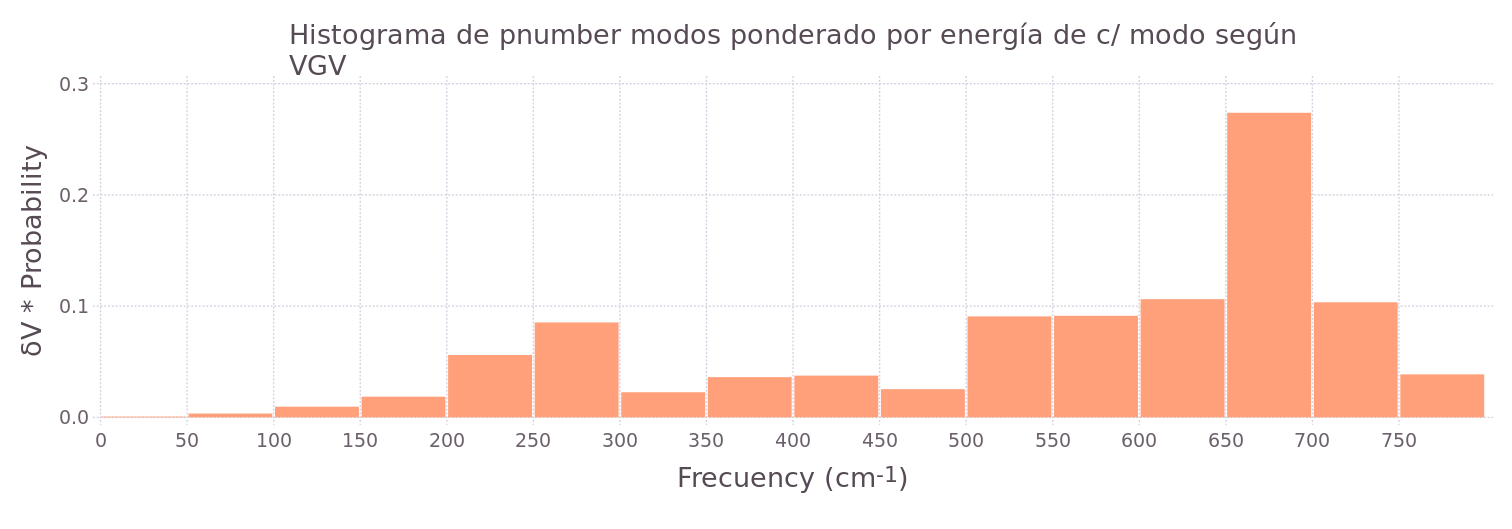

In [74]:
top_freq = maximum(evals_1m14_pnum) * 1.1 
bins_freq = collect(0:50:top_freq)

# Histograma ponderado
mode_freq_1m14_Whis, mode_freq_1m14_Wbins =
WeightedHist(evals_1m14_pnum, bins_freq, we_modes_1m14, true);

df_mode_freq_1m14_Whis =
DataFrame(Probability = mode_freq_1m14_Whis, Frequency =
mode_freq_1m14_Wbins);

pdf_mode_freq_1m14_Whis = plot(df_mode_freq_1m14_Whis, x="Frequency",
y="Probability", Geom.bar,
Guide.title("Histograma de pnumber modos ponderado por energía de c/ modo según
VGV"),
Guide.xlabel("Frecuency (cm<sup>-1</sup>)"),
Guide.xticks(ticks=collect(0:50:775)),
Guide.ylabel("δV * Probability", orientation=:vertical),
Theme(bar_spacing=2pt, grid_line_width=1pt,
default_color=colorant"LightSalmon",
minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size
= 20pt))

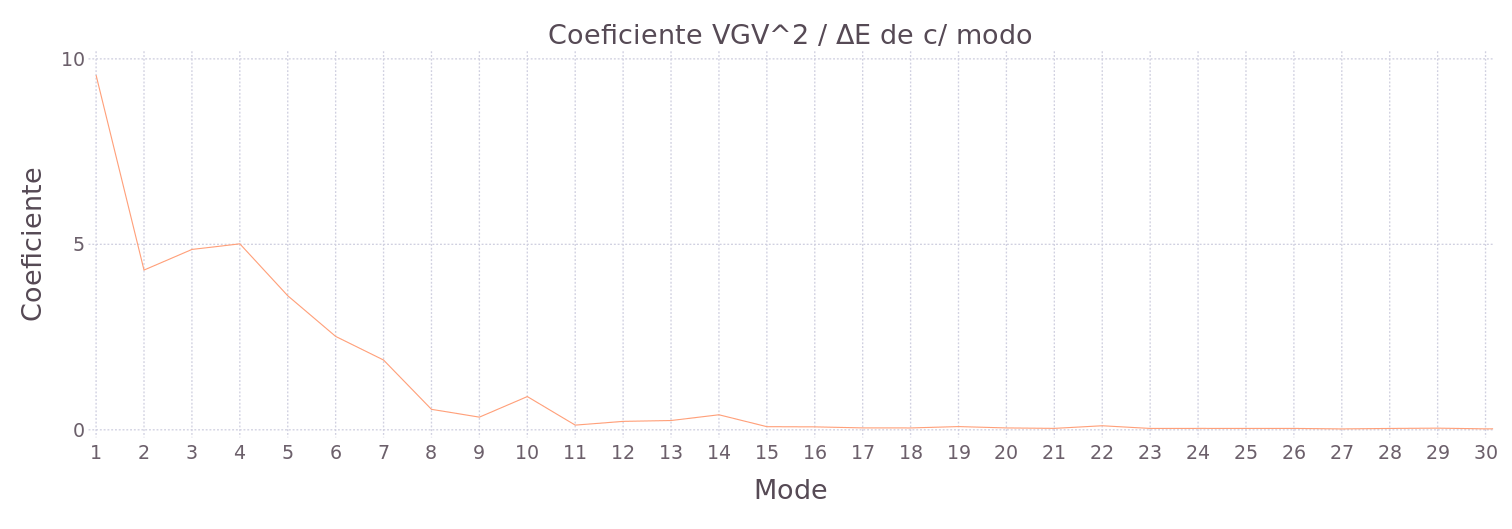

In [127]:
cfcte_modes_1m14 = (gdte_whole_1m14_pnum.^2) ./ e_modes_1m14

df_cfcte_modes_1m14 =
DataFrame(Coeficiente = cfcte_modes_1m14, Mode =
collect(1:pnumber_gdte_1m14))

pdf_cfcte_modes_1m14 = plot(df_cfcte_modes_1m14, x="Mode",
y="Coeficiente", Geom.line,
Guide.title("Coeficiente VGV^2 / ΔE de c/ modo"), Guide.xticks(ticks = collect(1:30)),
Coord.cartesian(xmax = 30),

Theme(bar_spacing=2pt, grid_line_width=1pt,
default_color=colorant"LightSalmon",
minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size
= 20pt))

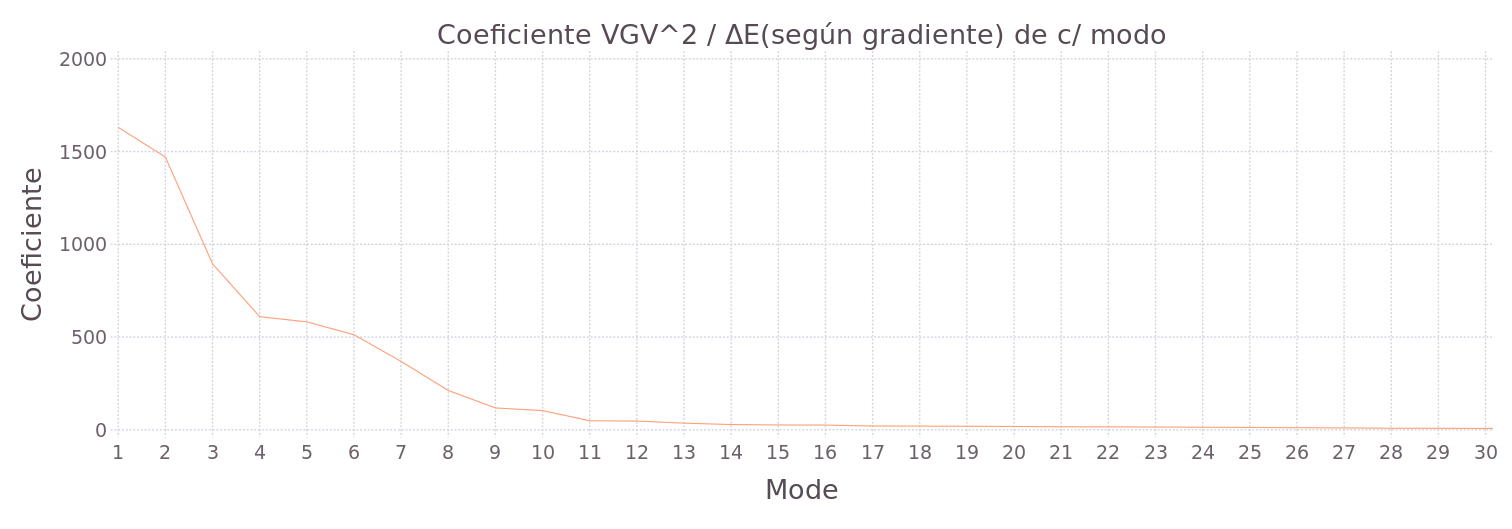

In [126]:
wcfcte_modes_1m14 = (gdte_whole_1m14_pnum.^2) ./ we_modes_1m14;

df_wcfcte_modes_1m14 =
DataFrame(Coeficiente = wcfcte_modes_1m14, Mode =
collect(1:pnumber_gdte_1m14))

pdf_wcfcte_modes_1m14 = plot(df_wcfcte_modes_1m14, x="Mode",
y="Coeficiente", Geom.line,
Guide.title("Coeficiente VGV^2 / ΔE(según gradiente) de c/ modo"), Guide.xticks(ticks = collect(1:30)),
Coord.cartesian(xmax = 30),

Theme(bar_spacing=2pt, grid_line_width=1pt,
default_color=colorant"LightSalmon",
minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size
= 20pt))

## T4L

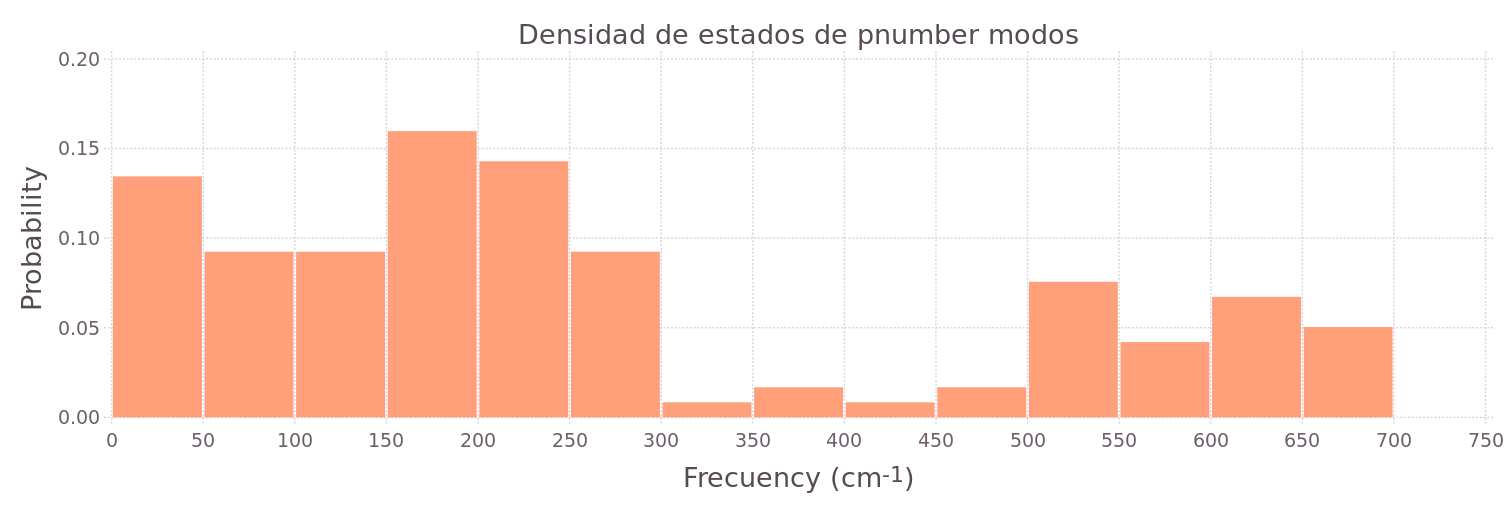

In [75]:
top_freq = maximum(evals_256l_pnum) * 1.1 
bins_freq = collect(0:50:top_freq)
unos_freq = repeat([1.0], inner=[length(evals_256l_pnum)])

# Histograma no ponderado
mode_freq_256l_his, mode_freq_256l_bins =
WeightedHist(evals_256l_pnum, bins_freq, unos_freq, true);

df_mode_freq_256l_his =
DataFrame(Probability = mode_freq_256l_his, Frequency =
mode_freq_256l_bins);

pdf_mode_freq_256l_his = plot(df_mode_freq_256l_his, x="Frequency",
y="Probability", Geom.bar,
Guide.title("Densidad de estados de pnumber modos"),
Guide.xlabel("Frecuency (cm<sup>-1</sup>)"),
Guide.xticks(ticks=collect(0:50:775)),
Guide.ylabel("Probability", orientation=:vertical),
Theme(bar_spacing=2pt, grid_line_width=1pt,
default_color=colorant"LightSalmon",
minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size
= 20pt))

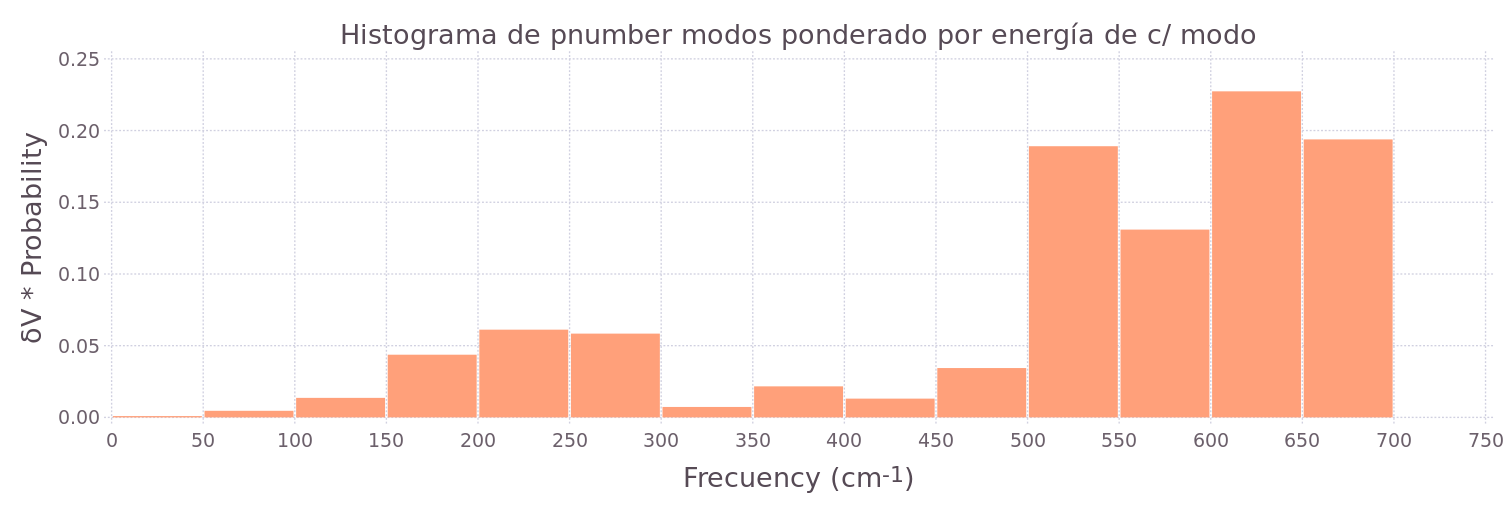

In [76]:
# Los bins van de 0 a la fqcia más alta + 10%
top_freq = maximum(evals_256l_pnum) * 1.1 
bins_freq = collect(0:50:top_freq)

# Histograma ponderado
mode_freq_256l_Whis, mode_freq_256l_Wbins =
WeightedHist(evals_256l_pnum, bins_freq, e_modes_256l, true);

df_mode_freq_256l_Whis =
DataFrame(Probability = mode_freq_256l_Whis, Frequency =
mode_freq_256l_Wbins);

pdf_mode_freq_256l_Whis = plot(df_mode_freq_256l_Whis, x="Frequency",
y="Probability", Geom.bar,
Guide.title("Histograma de pnumber modos ponderado por energía de c/ modo"),
Guide.xlabel("Frecuency (cm<sup>-1</sup>)"),
Guide.xticks(ticks=collect(0:50:775)),
Guide.ylabel("δV * Probability", orientation=:vertical),
Theme(bar_spacing=2pt, grid_line_width=1pt,
default_color=colorant"LightSalmon",
minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size
= 20pt))

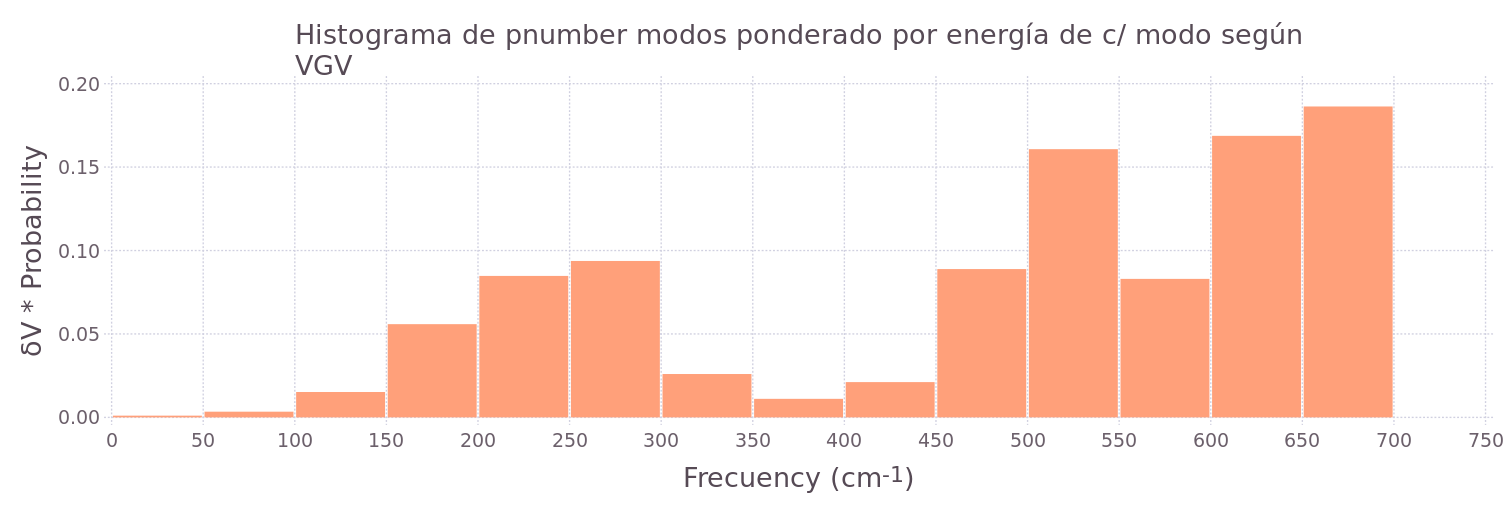

In [77]:
top_freq = maximum(evals_256l_pnum) * 1.1 
bins_freq = collect(0:50:top_freq)

# Histograma ponderado
mode_freq_256l_Whis, mode_freq_256l_Wbins =
WeightedHist(evals_256l_pnum, bins_freq, we_modes_256l, true);

df_mode_freq_256l_Whis =
DataFrame(Probability = mode_freq_256l_Whis, Frequency =
mode_freq_256l_Wbins);

pdf_mode_freq_256l_Whis = plot(df_mode_freq_256l_Whis, x="Frequency",
y="Probability", Geom.bar,
Guide.title("Histograma de pnumber modos ponderado por energía de c/ modo según
VGV"),
Guide.xlabel("Frecuency (cm<sup>-1</sup>)"),
Guide.xticks(ticks=collect(0:50:775)),
Guide.ylabel("δV * Probability", orientation=:vertical),
Theme(bar_spacing=2pt, grid_line_width=1pt,
default_color=colorant"LightSalmon",
minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size
= 20pt))

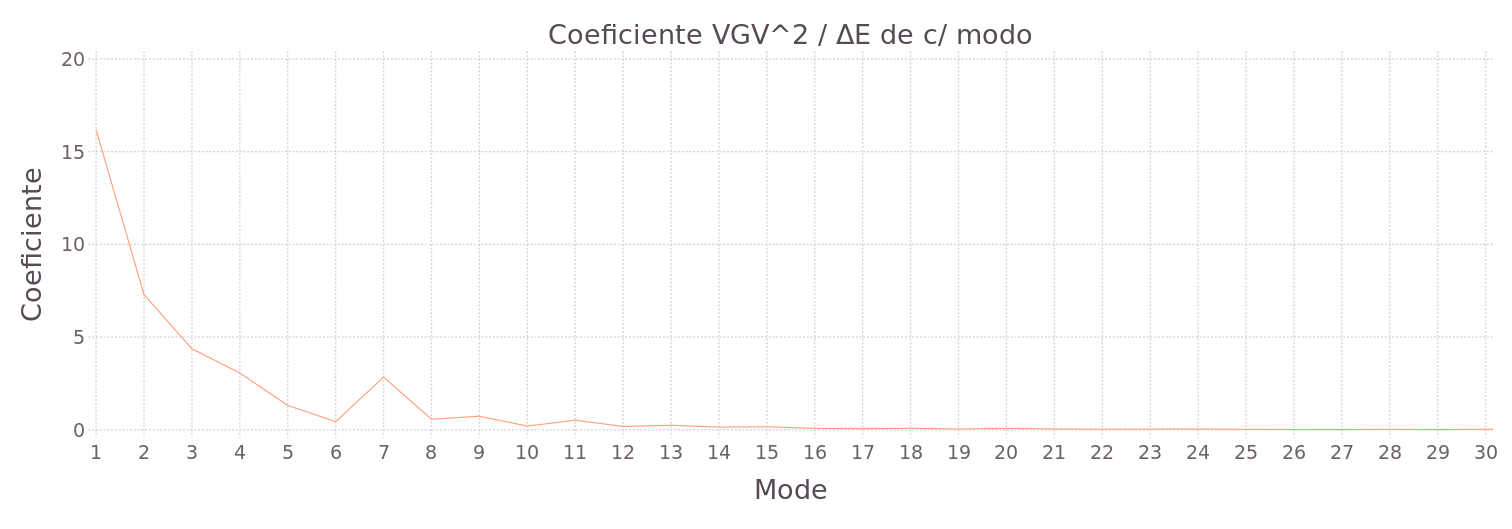

In [124]:
cfcte_modes_256l = (gdte_whole_256l_pnum.^2) ./ e_modes_256l

df_cfcte_modes_256l =
DataFrame(Coeficiente = cfcte_modes_256l, Mode =
collect(1:pnumber_gdte_256l))

pdf_cfcte_modes_256l = plot(df_cfcte_modes_256l, x="Mode",
y="Coeficiente", Geom.line,
Guide.title("Coeficiente VGV^2 / ΔE de c/ modo"), Guide.xticks(ticks = collect(1:30)),
Coord.cartesian(xmax = 30),

Theme(bar_spacing=2pt, grid_line_width=1pt,
default_color=colorant"LightSalmon",
minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size
= 20pt))

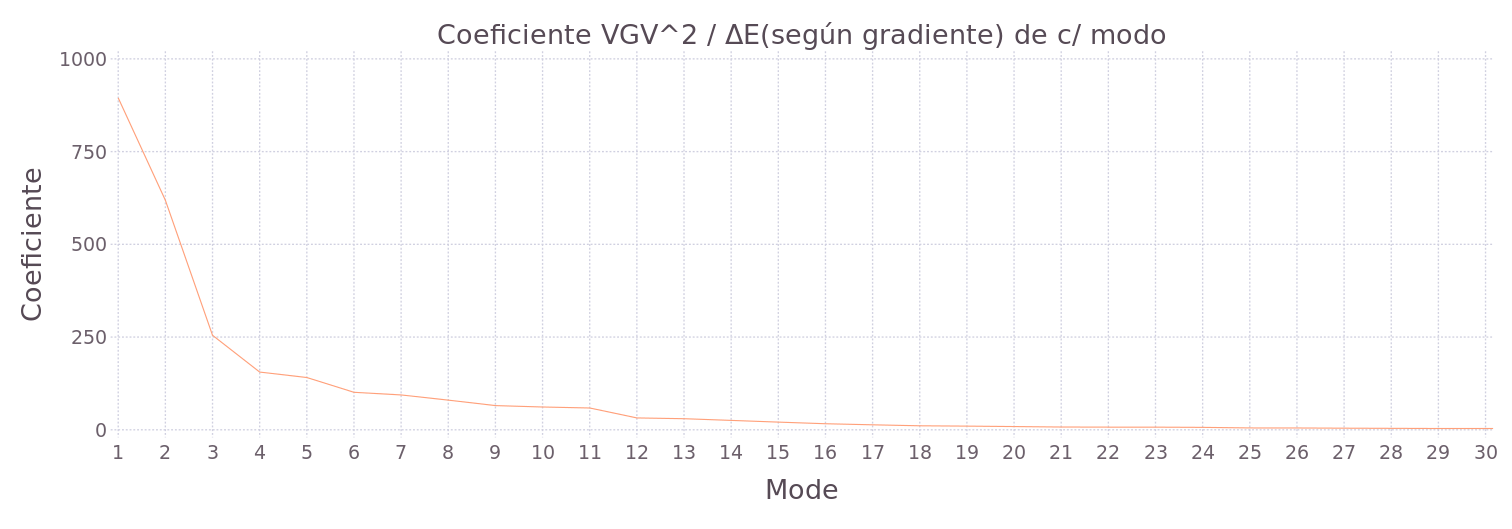

In [125]:
wcfcte_modes_256l = (gdte_whole_256l_pnum.^2) ./ we_modes_256l;

df_wcfcte_modes_256l =
DataFrame(Coeficiente = wcfcte_modes_256l, Mode =
collect(1:pnumber_gdte_256l))

pdf_wcfcte_modes_256l = plot(df_wcfcte_modes_256l, x="Mode",
y="Coeficiente", Geom.line,
Guide.title("Coeficiente VGV^2 / ΔE(según gradiente) de c/ modo"), Guide.xticks(ticks = collect(1:30)),
Coord.cartesian(xmax = 30),

Theme(bar_spacing=2pt, grid_line_width=1pt,
default_color=colorant"LightSalmon",
minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size
= 20pt))

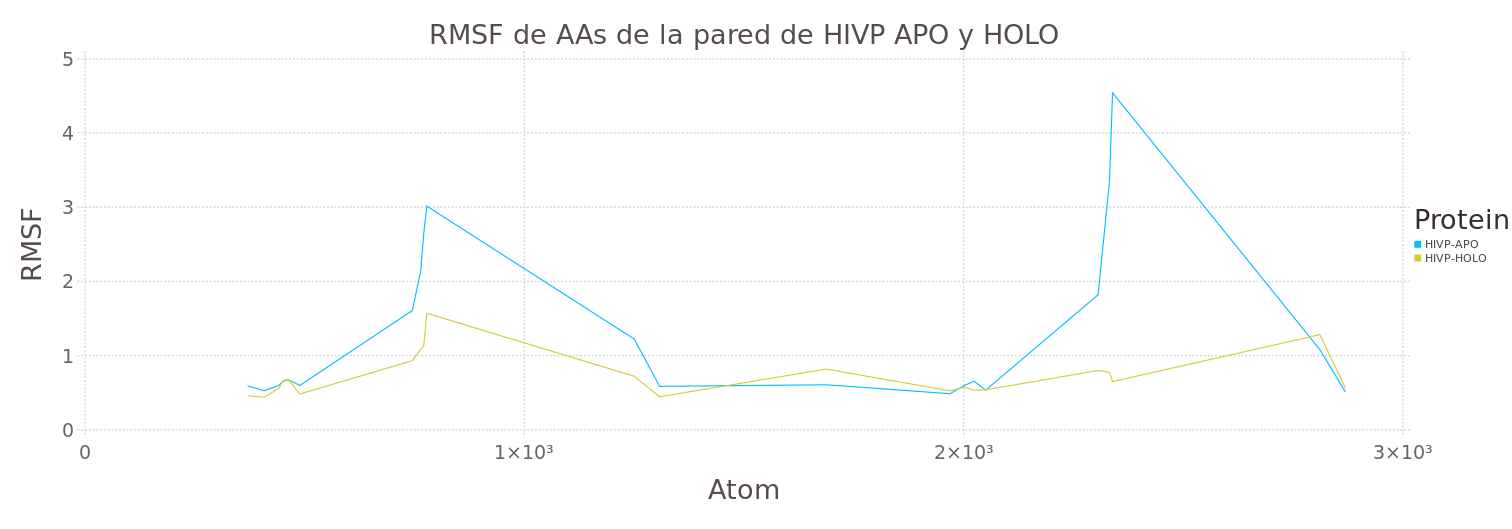

In [149]:
df_rmsf = DataFrame(RMSF = [ readdlm("/home/german/labo/16/exs/run/1hvr_apo/rmsf/rmsf_1hvr_apo")[:, 2] ;
    readdlm("/home/german/labo/16/exs/run/1hvr_hol/rmsf/rmsf_1hvr_hol")[:, 2] ],
    Atom = repeat(readdlm("/home/german/labo/16/exs/run/1hvr_apo/rmsf/rmsf_1hvr_apo")[:, 1], outer = [2]),
    Protein = repeat(["HIVP-APO" ; "HIVP-HOLO"], inner = [22]))

plot(df_rmsf, x = "Atom", y = "RMSF", color = "Protein", Geom.line,
Guide.title("RMSF de AAs de la pared de HIVP APO y HOLO"),

Theme(bar_spacing=2pt, grid_line_width=1pt,
minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size
= 20pt))

# P/ publicación

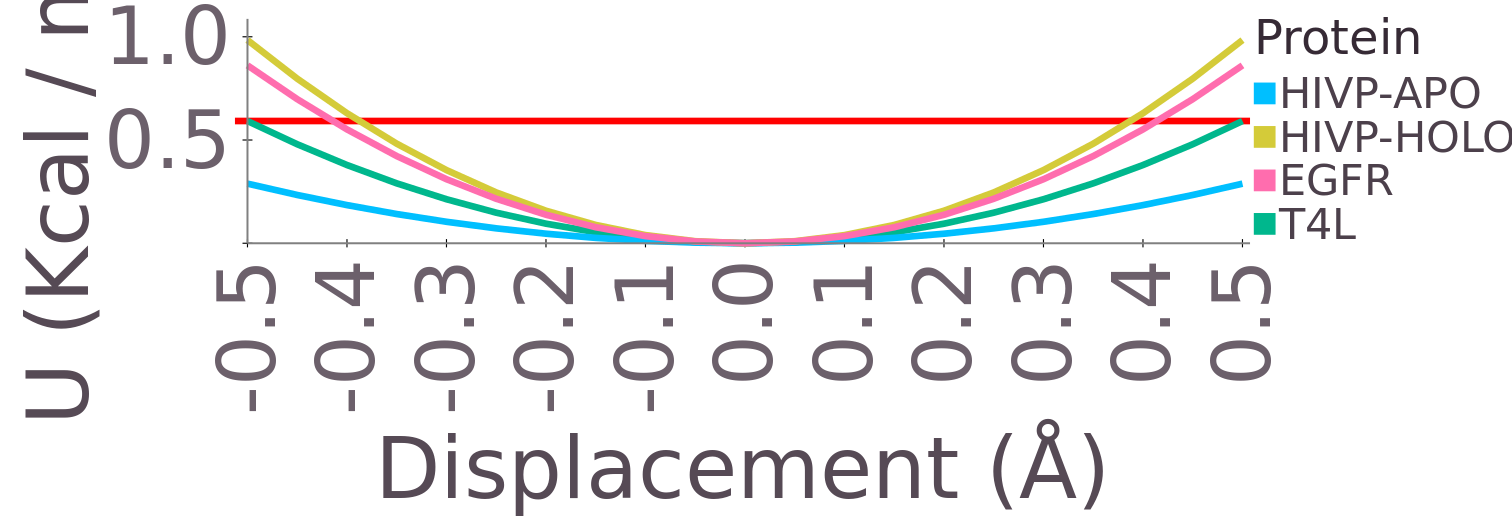

In [21]:
# Compilo en un dataframe.
df_E_pnum = DataFrame(U = [ E_1hvr_apo_pnum ; E_1hvr_hol_pnum ; E_1m14_pnum ; E_256l_pnum ],
Displacement = repeat(collect(min:1:max) * 5e-2, outer = [4]), 
Protein = repeat(["HIVP-APO" ; "HIVP-HOLO" ; "EGFR" ; "T4L"], inner = [points]))

lyr_x_ticks = layer(x =  collect(-0.5:0.1:0.5), xend = collect(-0.5:0.1:0.5),
            y = repeat([-0.02], inner = [11]), yend = repeat([0.02], inner = [11]),
            Geom.segment, Theme(default_color=colorant"Black"))
lyr_y_ticks = layer(y =  collect(0.:0.5:1.), yend = collect(0.:0.5:1.),
            x = repeat([-0.505], inner = [3]), xend = repeat([-0.495], inner = [3]),
            Geom.segment, Theme(default_color=colorant"Black"))

pdf_E_pnum = plot(df_E_pnum, y = "U", x = "Displacement", color = "Protein", Geom.line,
yintercept = [KBT], Geom.hline(color = "red"), 
lyr_x_ticks, lyr_y_ticks,
Guide.xticks(ticks = collect(min:2:max) * 5e-2), Guide.yticks(ticks = collect(0.5:0.5:1.)), 
Coord.cartesian(ymax = 1.05),
Guide.xlabel("Displacement (Å)"), Guide.ylabel("U (Kcal / mol)", orientation =:vertical),

Guide.annotation(compose(context(), line([(-0.5, 0), (0.55, 0.), ]),
Compose.stroke("gray"), Compose.fill("gray"))),
Guide.annotation(compose(context(), line([(-0.5, 0.), (-0.5, 1.1), ]),
Compose.stroke("gray"), Compose.fill("gray"))),

Theme(line_width=5pt, grid_line_width=0pt, default_color=colorant"deepskyblue",
minor_label_font_size = 60pt, major_label_font_size = 64pt, key_label_font_size = 32pt,
key_title_font_size = 36pt))

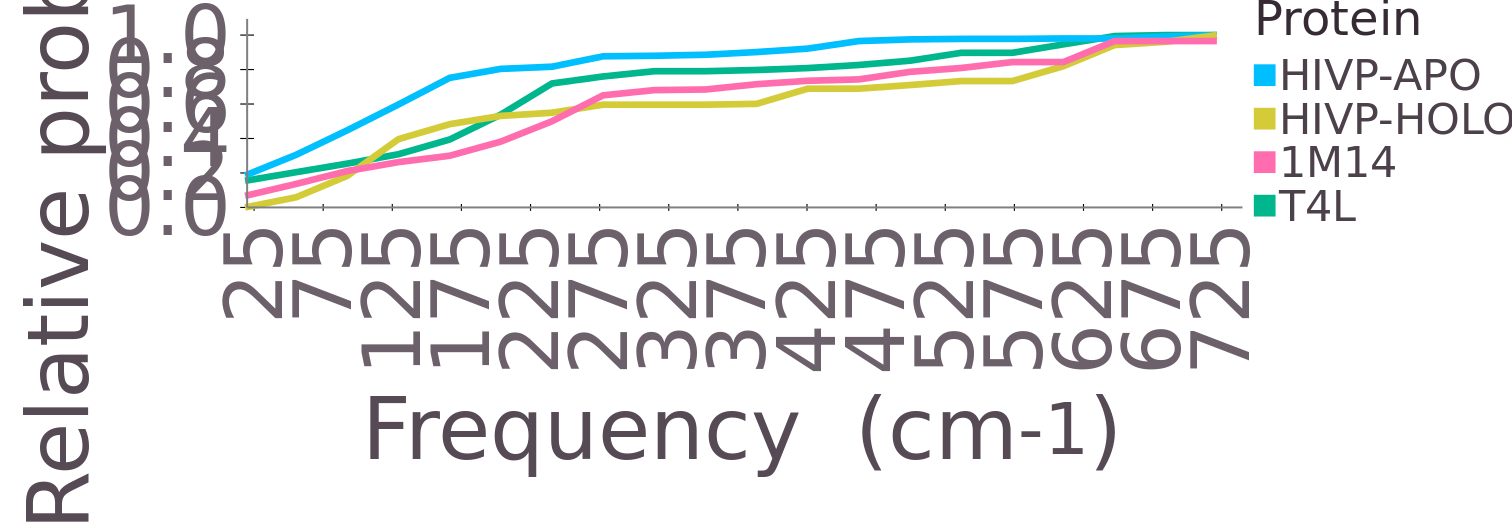

In [23]:
lyr_x_ticks = layer(x =  collect(25:50:725), xend = collect(25:50:725),
            y = repeat([-0.02], inner = [16]), yend = repeat([0.02], inner = [16]),
            Geom.segment, Theme(default_color=colorant"Black"))
lyr_y_ticks = layer(y =  collect(0.:0.2:1.), yend = collect(0.:0.2:1.),
            x = repeat([15], inner = [6]), xend = repeat([25], inner = [6]),
            Geom.segment, Theme(default_color=colorant"Black"))


pdf_acu_pnum = plot(df_acu_pnum, y = "Fraction", x = "Frequency", color = "Protein", Geom.line,
lyr_x_ticks, lyr_y_ticks,
Coord.cartesian(ymax = 1.05, xmin = minimum(df_acu[:Frequency])* .9, xmax = 740),
Guide.xticks(ticks = collect(25:50:750)), Guide.yticks(ticks = collect(0:0.2:1.)),
Guide.xlabel("Frequency  (cm<sup>-1</sup>)"), Guide.ylabel("Relative probability"),

Guide.annotation(compose(context(), line([(20, 0.), (740, 0.), ]),
Compose.stroke("gray"), Compose.fill("gray"))),
Guide.annotation(compose(context(), line([(20, 1.1), (20, 0.), ]),
Compose.stroke("gray"), Compose.fill("gray"))),

Theme(line_width=5pt, grid_line_width=0pt, default_color=colorant"deepskyblue",
minor_label_font_size = 60pt, major_label_font_size = 64pt, key_label_font_size = 32pt,
key_title_font_size = 36pt))

## Guardo plots

In [24]:
out_filename_5_fig = string(main_dir, "paper/5-fig/5a-fig_pnum.png")
draw(PNG(out_filename_5_fig, 120cm, 40cm), pdf_E_pnum)

out_filename_5_fig = string(main_dir, "paper/5-fig/5b-fig_pnum.png")
draw(PNG(out_filename_5_fig, 120cm, 40cm), pdf_acu_pnum)